In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import re
from ast import literal_eval
from itertools import combinations
from collections import Counter

#Анализ врачей Москвы: СберЗдоровье и ПроДокторов

**Цель проекта**

Провести анализ данных о врачах Москвы, собранных с онлайн-платформ СберЗдоровье и ПроДокторов, с акцентом на географическое распределение, ценовую политику и рейтинги специалистов.


**Описание источников данных**


**СберЗдоровье** — цифровая платформа, предоставляющая пользователям возможность **записи к врачам**, а также информацию о стоимости приёма, рейтингах и доступности специалистов по районам города.


**ПроДокторов** — **независимый ресурс, ориентированный на отзывы пациентов** и рейтинговую оценку врачей и клиник, что позволяет судить о качестве оказываемых медицинских услуг.


**Этапы работы**

1)Сбор и структурирование данных о врачах Москвы с обеих платформ.

2)Сравнительный анализ стоимости приёма, рейтингов, географии распределения специалистов, анализ текста отзывов.

4)Выявление лучших врачей и районов, где сочетание цены, рейтинга и доступности является наиболее выгодным для пациента.


**MVP - Сервис, который поможет лечиться выгодно**


**Скибиди ДокДок** — прототип, который:


-подсказывает лучшие предложения по рейтингу и цене в выбранном районе;


-показывает средние показатели по Москве;


-помогает пользователю выбрать оптимального врача с учётом репутации, цены и геолокации.


**Долгосрочная цель**


-Построение единого профиля врача с расчётом агрегированного рейтинга, основанного на данных разных платформ.
Для этого необходим детальный анализ различий между источниками — в ценах, рейтингах и опыте специалистов.

ТУТ ОПИСАНИЕ СТРУКТУРЫ НАШИХ ДАТАСЕТОВ И ВСЕХ ПРИЗНАКОВ

#Датасет

In [5]:
doctors = pd.read_csv('https://github.com/yyaroslavskiy/cuddly-chainsaw/raw/refs/heads/develop/eda/merge/doctors.csv')

In [4]:
review_rate = pd.read_csv('mean_review_rate.csv') #записать ссылкой

doctors = doctors.merge(review_rate, left_on='link_sber', right_on='doctor_link', how='left')

doctors = doctors.merge(review_rate, left_on='link_prod', right_on='doctor_link', how='left')

NameError: name 'review_rate' is not defined

In [ ]:
# doctors — твой основной датасет
# rates — новый датасет с колонками doctor_link, rate, source

# Разделим на 2 подтаблицы по источнику
ratings_sber = ratings[ratings['source'] == 'sber'][['doctor_link', 'rate']].rename(columns={'rate': 'rating_sber_detail'})
ratings_prod = ratings[ratings['source'] == 'prodoctorov'][['doctor_link', 'rate']].rename(columns={'rate': 'rating_prod_detail'})

# Соединяем по ссылке
doctors_merged = doctors.copy()
doctors_merged = doctors_merged.merge(rating_sber, left_on='link_sber', right_on='doctor_link', how='left')
doctors_merged = doctors_merged.merge(rating_prod, left_on='link_prod', right_on='doctor_link', how='left')

# Убираем лишние колонки doctor_link
doctors_merged.drop(columns=['doctor_link_x', 'doctor_link_y'], inplace=True, errors='ignore')

print(doctors_merged.shape)
doctors_merged[['rating_sber', 'rating_sber_detail', 'rating_prod', 'rating_prod_detail']].head()


In [6]:
del doctors['Unnamed: 0']

In [7]:
doctors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38865 entries, 0 to 38864
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   38865 non-null  object 
 1   experience             16946 non-null  float64
 2   rating_sber            31918 non-null  float64
 3   review_count_sber      31919 non-null  float64
 4   price_sber             4199 non-null   float64
 5   link_sber              31919 non-null  object 
 6   clinics_count_sber     31919 non-null  float64
 7   clinic_1_name_sber     4360 non-null   object 
 8   clinic_1_address_sber  4360 non-null   object 
 9   clinic_1_metro_sber    4304 non-null   object 
 10  clinic_2_name_sber     868 non-null    object 
 11  clinic_2_address_sber  868 non-null    object 
 12  clinic_2_metro_sber    827 non-null    object 
 13  clinic_3_name_sber     142 non-null    object 
 14  clinic_3_address_sber  142 non-null    object 
 15  cl

In [8]:
doctors.describe()

,experience,rating_sber,review_count_sber,price_sber,clinics_count_sber,price_prod,rating_prod,review_count_prod,clinics_count_prod
count,16946.000000,31918.000000,31919.000000,4199.000000,31919.000000,5894.000000,17214.000000,25657.000000,25657.000000
mean,21.661159,4.250658,5.814812,5010.827102,0.169523,4698.710892,2.557976,7.539151,1.482286
std,12.634724,0.497346,31.287880,3932.463460,0.471099,4039.904336,1.545650,18.488260,0.816692
min,1.000000,0.000000,0.000000,1000.000000,0.000000,500.000000,0.000000,0.000000,1.000000
25%,11.000000,4.000000,0.000000,3000.000000,0.000000,2800.000000,1.500000,0.000000,1.000000
50%,20.000000,4.300000,0.000000,3700.000000,0.000000,3500.000000,2.500000,2.000000,1.000000
75%,31.000000,4.500000,3.000000,5500.000000,0.000000,5400.000000,3.900000,8.000000,2.000000
max,71.000000,5.000000,1131.000000,100000.000000,8.000000,150000.000000,5.000000,627.000000,13.000000


посмотрим пропуски(функция с сема)

In [9]:
#Воспользуемся следующей функцией, которая предоставляет отчет о пропусках в данных

def missing_values_table(df):
    """
    Функция возвращает резюме по пропущенным значениям
    """
    # Общее число пропусков
    mis_val = df.isnull().sum()

    # Процент пропусков
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Создадит таблицу с результатом
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Переименнуем колонки
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Отсортируем по проценту пропущенных значений
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Выведем некоторую информацию
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")

    return mis_val_table_ren_columns

missing_values_table(doctors)

Your selected dataframe has 33 columns.
There are 30 columns that have missing values.


,Missing Values,% of Total Values
clinic_3_metro_sber,38732,99.7
clinic_3_address_sber,38723,99.6
clinic_3_name_sber,38723,99.6
clinic_2_metro_sber,38038,97.9
clinic_2_address_sber,37997,97.8
clinic_2_name_sber,37997,97.8
clinic_3_metro_prod,36627,94.2
clinic_3_name_prod,36251,93.3
clinic_3_address_prod,36251,93.3
price_sber,34666,89.2


#Платформа, с которой взяли информацию о враче

FE - добавление колонки источника `'doctor_source'` откуда мы взяли врача

In [10]:
def get_doctor_source(row):
    has_sber = pd.notna(row['link_sber'])
    has_prod = pd.notna(row['link_prod'])

    if has_sber and has_prod:
        return 'Обе платформы'
    elif has_sber:
        return 'SberHealth'
    elif has_prod:
        return 'ProDoctorov'

doctors['doctor_source'] = doctors.apply(get_doctor_source, axis=1)

In [11]:
doctors

,name,experience,rating_sber,review_count_sber,price_sber,link_sber,clinics_count_sber,clinic_1_name_sber,clinic_1_address_sber,clinic_1_metro_sber,...,clinic_2_name_prod,clinic_2_address_prod,clinic_2_metro_prod,clinic_3_name_prod,clinic_3_address_prod,clinic_3_metro_prod,speciality,is_kids,is_adults,doctor_source
0,Абросимова Елена Владимировна,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,['терапевт'],False,True,ProDoctorov
1,Абросимова Елена Владимировна,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,['терапевт'],False,True,ProDoctorov
2,Агеева Наталья Юрьевна,18.0,4.5,0.0,3500.0,https://docdoc.ru/doctor/Ageeva_Natalya_12,1.0,Будь Здоров на Рязанском проспекте,"г. Москва, ул. Рязанский пр-т, д. 2Б",Нижегородская,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,SberHealth
3,Агеева Наталья Юрьевна,NaN,4.0,0.0,NaN,https://docdoc.ru/doctor/Ageeva_Natalya_3,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,SberHealth
4,Акимова Анна Владимировна,18.0,4.3,0.0,NaN,https://docdoc.ru/doctor/Akimova_Anna_7,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,SberHealth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38860,Ященко Елена Николаевна,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"['акушер', 'детский гинеколог', 'гинеколог']",True,True,ProDoctorov
38861,Ященко Ирина Анатольевна,30.0,4.7,2.0,NaN,https://docdoc.ru/doctor/Yashtenko_Irina,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"['реабилитолог', 'невролог']",False,True,Обе платформы
38862,Ящина Ольга Владимировна,NaN,4.0,3.0,NaN,https://docdoc.ru/doctor/Yashtina_Olga,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"['остеопат', 'терапевт']",False,True,Обе платформы
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"['акушер', 'гинеколог-хирург', 'гинеколог']",False,True,Обе платформы


In [12]:
doctors['doctor_source'].value_counts()

,count
doctor_source,
Обе платформы,18711
SberHealth,13208
ProDoctorov,6946


#ФИО (`name`)

Всего в датасете - 38 865 строк

In [13]:
doctors.shape[0]

38865

Уникальных фио - 38441


In [14]:
doctors.name.value_counts().size

38441

230 фио повторяются более одного раза

In [15]:
print((doctors.name.value_counts() > 1).sum())

230


Постмотрим на кол-во слов в фио

In [16]:
doctors.name.str.split().apply(len).value_counts()

,count
name,
3,38086
4,646
2,126
5,7


In [ ]:
# doctors.name.str.split().apply(len)[doctors.name.str.split().apply(len) == 5]

Встречаются лищние \t, но в основном:

- `в случае 2 слов` - это только фамилия имя
- `в случае 4 слов` - это дополнительная фамилия, чаще в скобках. например, фамилия до/после замужества. либо еще встречаются иностранные полные имена
- `в случае 5 слов` - либо несколько фамилий/отчеств, либо иностранные полныеимена

# Опыт врача (`experience`)

In [17]:
def categorize_experience(exp):
    if pd.isna(exp):
        return 'No value'
    elif exp <= 5:
        return '0-5 лет'
    elif exp <= 10:
        return '6-10 лет'
    elif exp <= 15:
        return '11-15 лет'
    elif exp <= 20:
        return '16-20 лет'
    elif exp <= 30:
        return '21-30 лет'
    else:
        return 'Более 30 лет'

doctors['experience_category'] = doctors['experience'].apply(categorize_experience)
category_order = ['No value', '0-5 лет', '6-10 лет', '11-15 лет', '16-20 лет', '21-30 лет', 'Более 30 лет']

In [18]:
doctors

,name,experience,rating_sber,review_count_sber,price_sber,link_sber,clinics_count_sber,clinic_1_name_sber,clinic_1_address_sber,clinic_1_metro_sber,...,clinic_2_address_prod,clinic_2_metro_prod,clinic_3_name_prod,clinic_3_address_prod,clinic_3_metro_prod,speciality,is_kids,is_adults,doctor_source,experience_category
0,Абросимова Елена Владимировна,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,['терапевт'],False,True,ProDoctorov,21-30 лет
1,Абросимова Елена Владимировна,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,['терапевт'],False,True,ProDoctorov,Более 30 лет
2,Агеева Наталья Юрьевна,18.0,4.5,0.0,3500.0,https://docdoc.ru/doctor/Ageeva_Natalya_12,1.0,Будь Здоров на Рязанском проспекте,"г. Москва, ул. Рязанский пр-т, д. 2Б",Нижегородская,...,NaN,NaN,NaN,NaN,NaN,NaN,False,True,SberHealth,16-20 лет
3,Агеева Наталья Юрьевна,NaN,4.0,0.0,NaN,https://docdoc.ru/doctor/Ageeva_Natalya_3,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,SberHealth,No value
4,Акимова Анна Владимировна,18.0,4.3,0.0,NaN,https://docdoc.ru/doctor/Akimova_Anna_7,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,SberHealth,16-20 лет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38860,Ященко Елена Николаевна,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"['акушер', 'детский гинеколог', 'гинеколог']",True,True,ProDoctorov,No value
38861,Ященко Ирина Анатольевна,30.0,4.7,2.0,NaN,https://docdoc.ru/doctor/Yashtenko_Irina,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"['реабилитолог', 'невролог']",False,True,Обе платформы,21-30 лет
38862,Ящина Ольга Владимировна,NaN,4.0,3.0,NaN,https://docdoc.ru/doctor/Yashtina_Olga,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"['остеопат', 'терапевт']",False,True,Обе платформы,No value
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"['акушер', 'гинеколог-хирург', 'гинеколог']",False,True,Обе платформы,Более 30 лет


распределение врачей по опыту работы

/tmp/ipython-input-2410393555.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=doctors, y='experience_category', order=category_order, palette='viridis', alpha=0.8)


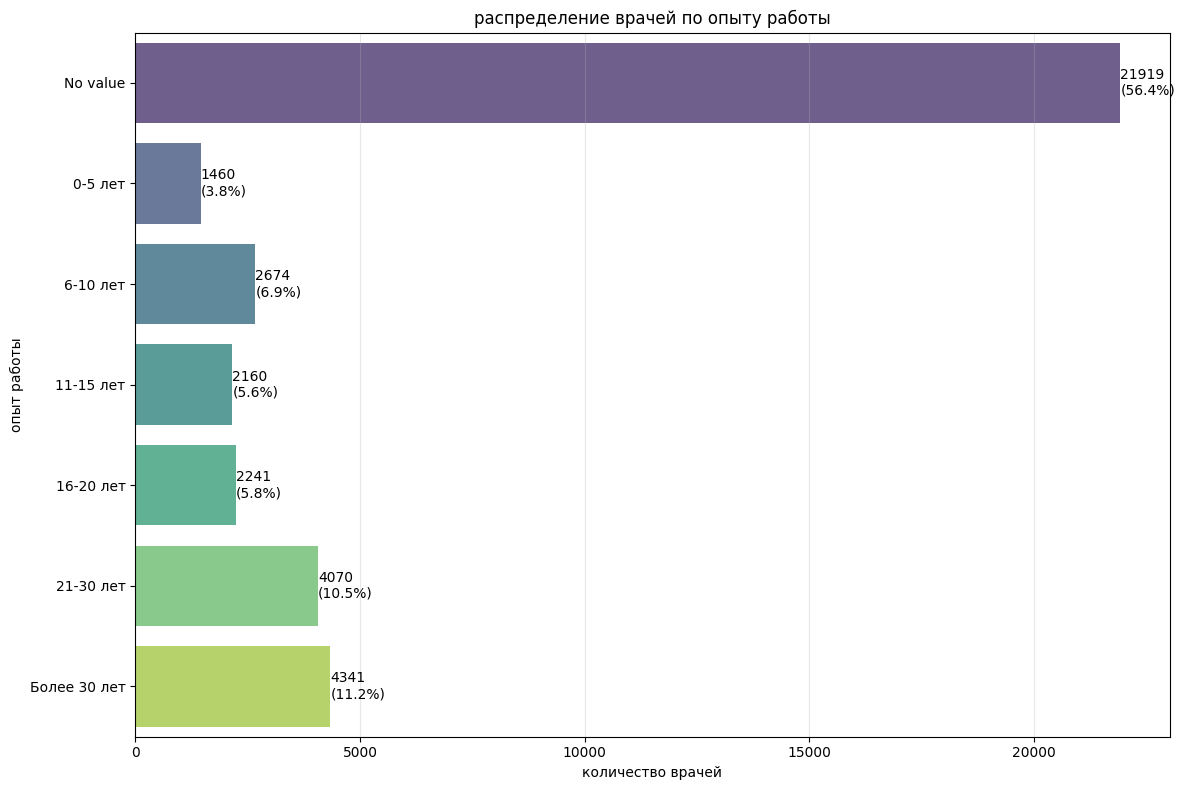

In [19]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(data=doctors, y='experience_category', order=category_order, palette='viridis', alpha=0.8)

total = len(doctors)
for p in ax.patches:
    width = p.get_width()
    percentage = f'{100 * width / total:.1f}%'
    x = p.get_x() + width
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{int(width)}\n({percentage})', (x, y), ha='left', va='center', fontsize=10)

plt.title('распределение врачей по опыту работы')
plt.xlabel('количество врачей')
plt.ylabel('опыт работы')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Видим, что больше половины значений пропущены. Восстановить их по другим показателям не представляется возможным. Посмотрим на распределение по квантилям и статистические показатели

In [20]:
doctors['experience'].describe()

,experience
count,16946.000000
mean,21.661159
std,12.634724
min,1.000000
25%,11.000000
50%,20.000000
75%,31.000000
max,71.000000


In [21]:
np.median(doctors[doctors.experience.notna()]['experience'])

np.float64(20.0)

In [22]:
stats.mode(doctors[doctors.experience.notna()]['experience'])

ModeResult(mode=np.float64(7.0), count=np.int64(671))

Видим, что по большей части врачи опытные (>10  лет опыта). Медиана практически сходится со средним значением. Значит данные сбалансированы, а выбросы не оказывают на них значимого влияния. Мода - 7 лет.

Text(0.5, 1.0, 'Experience KDE')

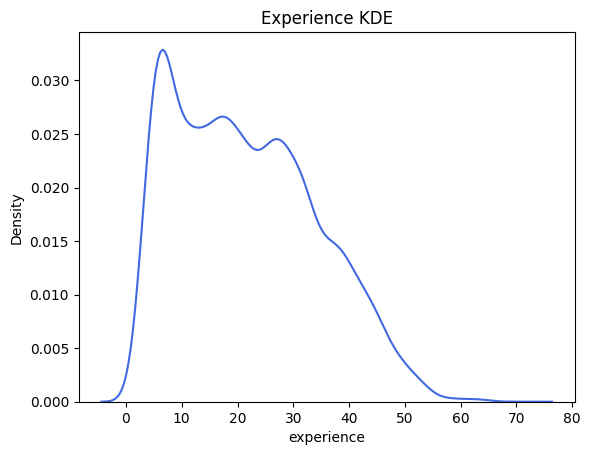

In [23]:
sns.kdeplot(doctors['experience'],color='royalblue')
plt.title("Experience KDE")

Видим пик плотности на опыте в 7 лет, затем интенсивность почти монотонно снижается. Возможно как-то связано с началом кризиса COVID-19 в 2020 году. Если исключить всплеск на этом участке, распределение можно было бы считать стремящимся к нормальному.

Ещё один пик - 16-19 лет. Совпадает с рекордным количеством обучающихся в ВУЗах России (2005-2010 годы). Третий пик на показателе 27-28 лет может быть связан с активным созданием новых университетов и развитием высшего образования в конце 1990-ых. [Источник данных.](https://rg.ru/2021/06/15/kolichestvo-rossiian-s-vysshim-obrazovaniem-prevysilo-31-procent.html)

Text(0.5, 1.0, 'Распределение показателя experience')

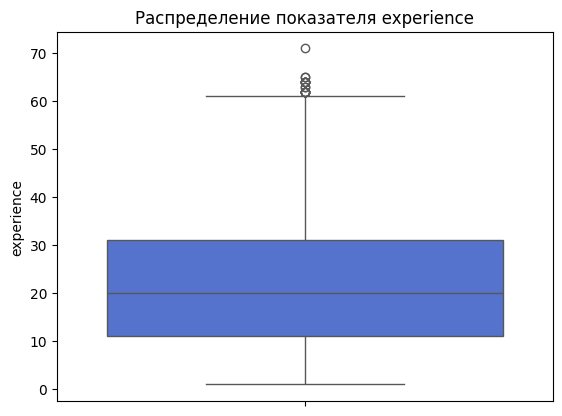

In [24]:
sns.boxplot(doctors['experience'],color='royalblue')
plt.title("Распределение показателя experience")

Минимум - 0 лет опыта, всё верно. Найдем верхние выбросы (выше конца уса / 3 IQR), если они есть.

In [25]:
q1 = doctors['experience'].quantile(0.25)
q3 = doctors['experience'].quantile(0.75)
iqr = q3 - q1

upper_whisker = q3 + 1.5 * iqr
upper_3iqr = q3 + 3 * iqr

print(upper_whisker, upper_3iqr, sep='\n')

61.0
91.0


Выше 3 IQR значений нет

In [26]:
doctors[doctors['experience'] > upper_3iqr].shape[0]

0

Выше верхнего уса 18 значений

In [27]:
doctors[doctors['experience'] > upper_whisker]['experience'].value_counts()

,count
experience,
62.0,7
64.0,6
63.0,2
65.0,2
71.0,1


Таким образом, врачи в пожилом возрасте с большим опытом также представлены на площадках

Можем сделать общий вывод, что по данному признаку много пропусков, однако данные распределены относительно симметрично и сбалансированно, выбросы не вносят большого вклада. Присутствует мультимодальность в виде трёх пиков, наибольший из них на показателе в 7 лет. В целом, если пренебречь структурными колебаниями, прослеживается тенденция нормального распределения.

/tmp/ipython-input-3485303716.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


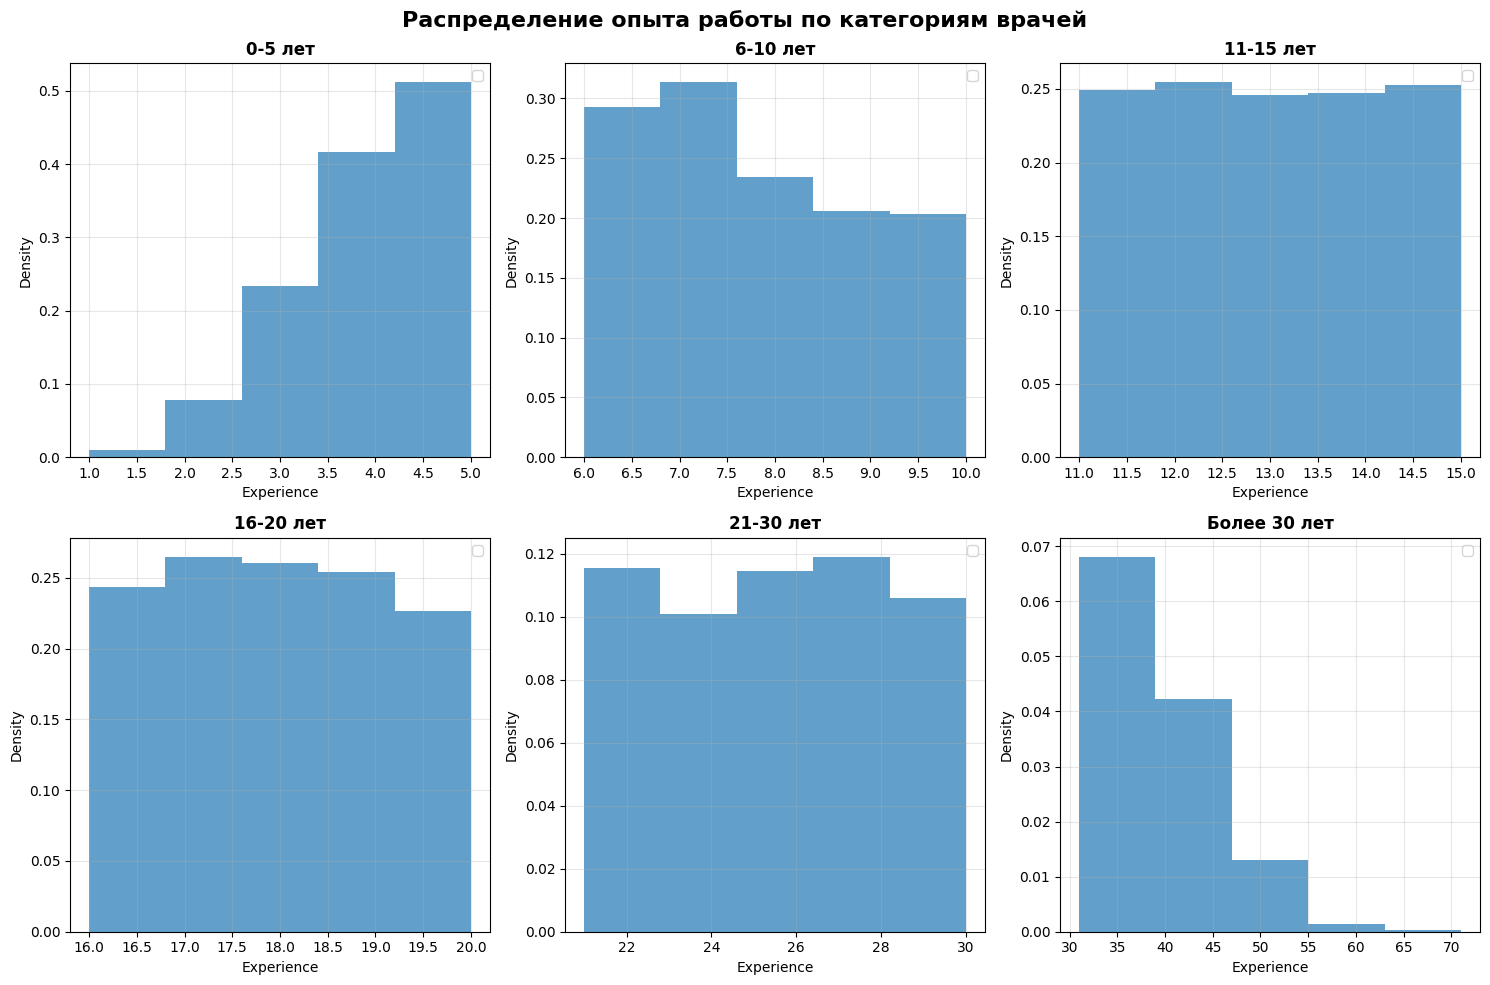

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределение опыта работы по категориям врачей', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.ravel()):
    category = category_order[idx+1]
    data = doctors[doctors.experience_category == category]['experience']

    hist = ax.hist(data, bins=5, alpha=0.7, density=True)

    ax.set_title(f'{category}', fontweight='bold')
    ax.set_xlabel('Experience')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend()


plt.tight_layout()
plt.show()

Видим сильную возрастающую тенденцию на категории 0-5 лет (выпуск врачей из ординатуры), небольшой спад после 7 лет (след от структурных изменений) и затем значительный спад после 30 лет (пенсия)

In [29]:
experienceAndPlatform = doctors.groupby('doctor_source')['experience'].agg(['mean','median','std','min','max'])
experienceAndPlatform

,mean,median,std,min,max
doctor_source,,,,,
ProDoctorov,21.664062,20.0,12.830587,2.0,62.0
SberHealth,24.975124,24.0,11.699332,3.0,61.0
Обе платформы,21.620717,20.0,12.638001,1.0,71.0


Врачи на сбере в среднем имеют чуть больше опыта

Распределение опыта работы на двух площадках

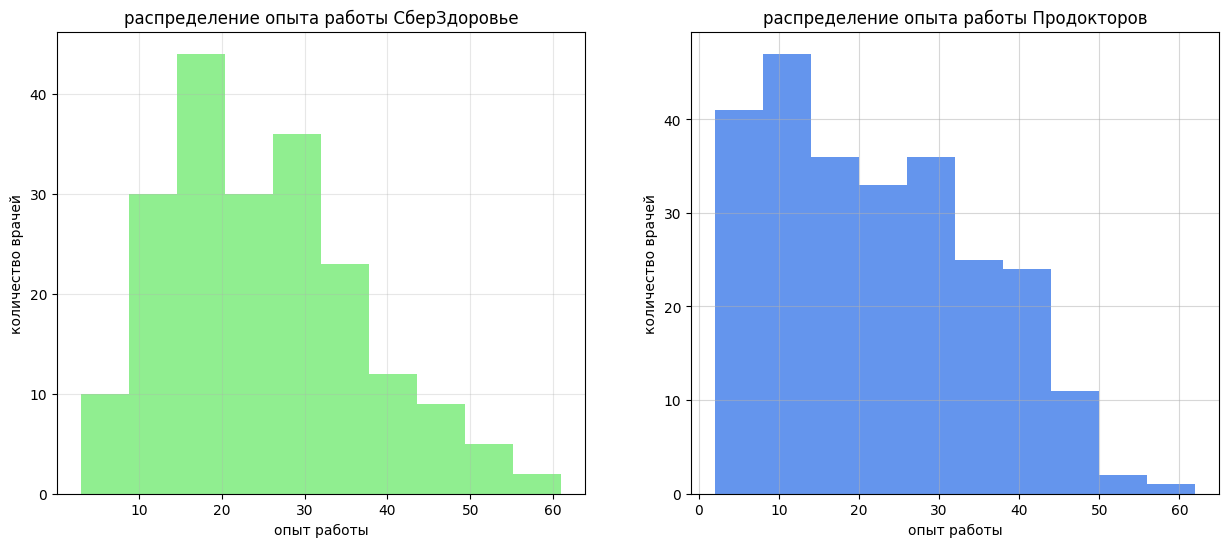

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(doctors[(doctors['doctor_source']=='SberHealth')]['experience'],color='lightgreen')
axes[0].set_title('распределение опыта работы СберЗдоровье')
axes[0].set_xlabel('опыт работы')
axes[0].set_ylabel('количество врачей')
axes[0].grid(alpha=0.3)

axes[1].hist(doctors[doctors['doctor_source']=='ProDoctorov']['experience'],color='cornflowerblue')
axes[1].set_title('распределение опыта работы Продокторов')
axes[1].set_xlabel('опыт работы')
axes[1].set_ylabel('количество врачей')
axes[1].grid(alpha=0.5)

Сбер:
Распределение напоминает нормальное и смещено немного вправо и больше врачей со стажем от 15 до 30 лет.
Пик примерно на 20–25 годах опыта.

Продокторов:
Распределение чуть более равномерное в диапазоне до 30 лет.
Пик ближе к 10–20 годам опыта.

Вывод:
В среднем и по медиане врачи действительно немного опытнее (что подтверждает предыдущая таблица).
**У ProDoctorov больше врачей с меньшим опытом — вероятно,** там чаще регистрируются специалисты в начале карьеры.
Оба распределения широкие

#Rating

In [31]:
doctors[['rating_sber', 'rating_prod']].describe()

,rating_sber,rating_prod
count,31918.000000,17214.000000
mean,4.250658,2.557976
std,0.497346,1.545650
min,0.000000,0.000000
25%,4.000000,1.500000
50%,4.300000,2.500000
75%,4.500000,3.900000
max,5.000000,5.000000


Интерпретация: У Сбера почти все рейтинги сосредоточены в диапазоне 4–5 У Продокторов на контрасте оценки более разбросаны, стандартное отклонение 1,5, встречаются низкие и нулевые значения.

Вывод - СберЗдоровье плохо различает врачей по качеству

Гипотезы:

1) Они могут удалять плохие комментарии (ну плохих оценок просто нет)

2) Могут банить врачей с плохими отзывами, чтобы не портить репутацию платформы тк это сервис по подбору врача, а не просто сервис для отзывов как Продокторов

***При объединении рейтингов важно учитывать, что отзывы на СберЗдоровье могут быть сглажены и несут меньше ценности.

распределение рейтингов Сбера и Продокторов

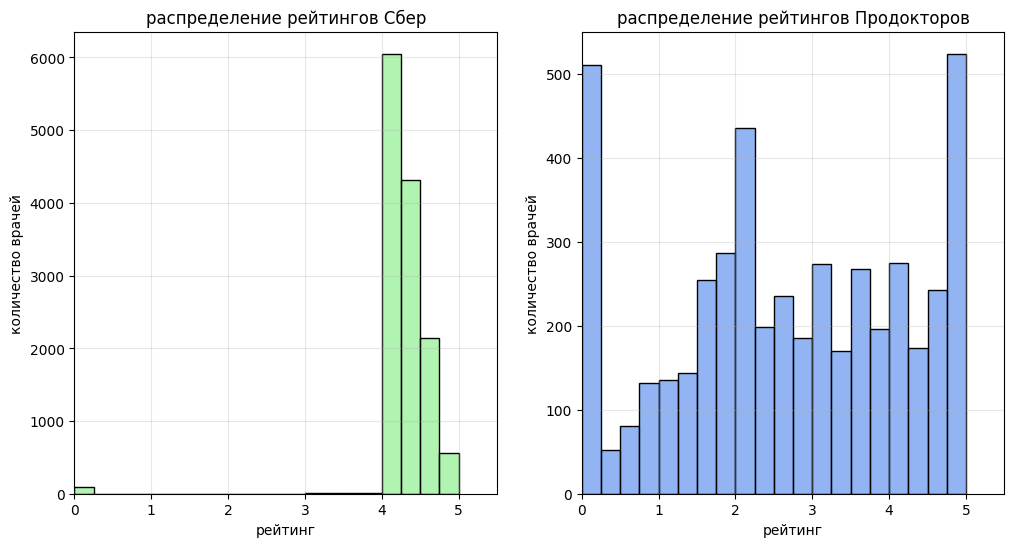

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sber_ratings = doctors[doctors['doctor_source'] == 'SberHealth']['rating_sber']
sns.histplot(sber_ratings, bins=20,alpha=0.7,color='lightgreen')
plt.title('распределение рейтингов Сбер')
plt.xlabel('рейтинг')
plt.ylabel('количество врачей')
plt.xlim(0, 5.5)
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sber_ratings = doctors[doctors['doctor_source'] == 'ProDoctorov']['rating_prod'].dropna()
sns.histplot(sber_ratings, bins=20,alpha=0.7,color='cornflowerblue')
plt.title('распределение рейтингов Продокторов')
plt.xlabel('рейтинг')
plt.ylabel('количество врачей')
plt.xlim(0, 5.5)
plt.grid(alpha=0.3)

Сравнение рейтингов врачей, которые есть на обеих платформах

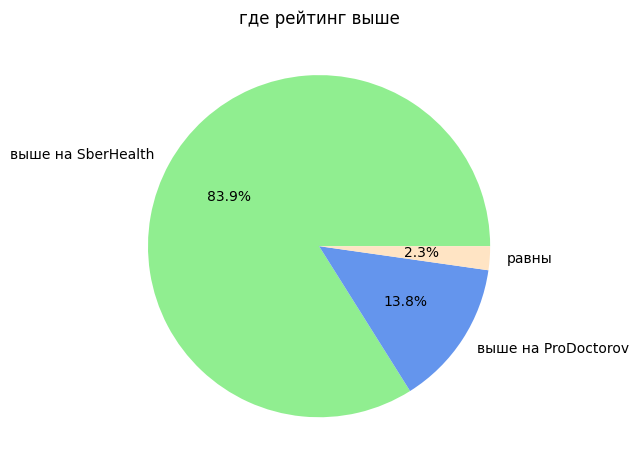

In [36]:
doctors_platforms_with_rating = doctors[
    (doctors['link_sber'].notna()) &
    (doctors['link_prod'].notna()) &
    (doctors['rating_sber'].notna()) &
    (doctors['rating_prod'].notna())].copy()

rating_diff = doctors_platforms_with_rating['rating_sber'] - doctors_platforms_with_rating['rating_prod']
higher_sber = (rating_diff > 0).sum()
higher_prod = (rating_diff < 0).sum()
equal = (rating_diff == 0).sum()

categories = ['выше на SberHealth', 'выше на ProDoctorov', 'равны']
values = [higher_sber, higher_prod, equal]
colors = ['lightgreen','cornflowerblue','bisque']
plt.pie(values, labels=categories, autopct='%1.1f%%',colors=colors)
plt.title('где рейтинг выше')

plt.tight_layout()
plt.show()

Оценки на Сбере в 84 процентах выше, это не норм... Посомтрим на распределение оценок

На сбере узкое распределение значений по оценкам - от 4 до 5. Видимо рейтинги приводят к верхнему диапазону и нормируют плохие оценки к шкале от 4 до 5, чтобы не отпугивать клиентов, ведь это сервис по подборке “хороших врачей"

In [37]:

doctors_norm = doctors.copy()

#фильтруем врачей с оценками [4, 5]
mask = doctors_norm['rating_sber'].between(4, 5)

#линейная нормализация: 4 это 1, 5 это 5
doctors_norm.loc[mask, 'rating_sber_norm'] = (
    (doctors_norm.loc[mask, 'rating_sber'] - 4) / (5 - 4) * (5 - 1) + 1
)

doctors_norm['rating_sber_norm'].describe()

,rating_sber_norm
count,31526.000000
mean,2.180892
std,1.033938
min,1.000000
25%,1.000000
50%,2.200000
75%,3.000000
max,5.000000


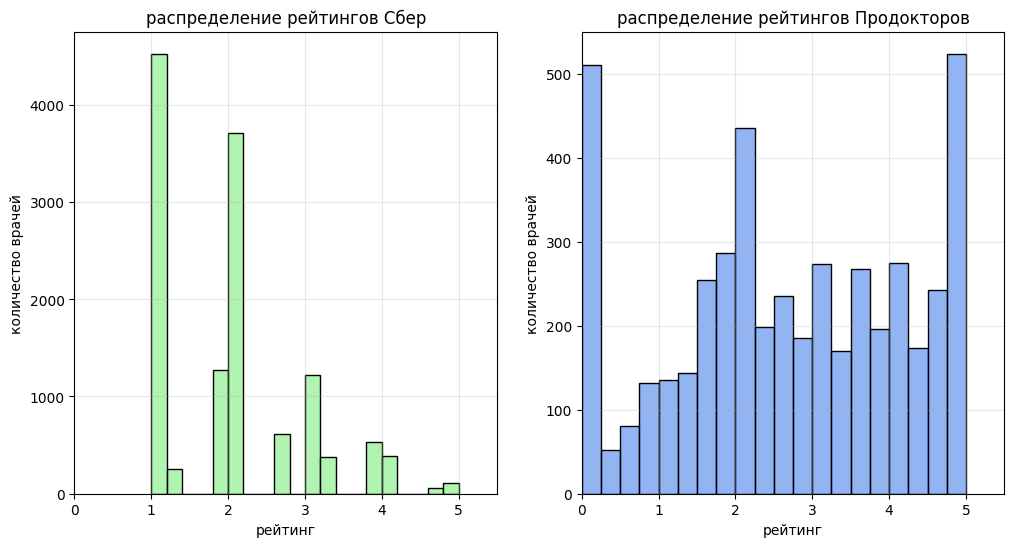

In [38]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sber_ratings = doctors_norm[doctors_norm['doctor_source'] == 'SberHealth']['rating_sber_norm']
sns.histplot(sber_ratings, bins=20,alpha=0.7,color='lightgreen')
plt.title('распределение рейтингов Сбер')
plt.xlabel('рейтинг')
plt.ylabel('количество врачей')
plt.xlim(0, 5.5)
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sber_ratings = doctors[doctors['doctor_source'] == 'ProDoctorov']['rating_prod'].dropna()
sns.histplot(sber_ratings, bins=20,alpha=0.7,color='cornflowerblue')
plt.title('распределение рейтингов Продокторов')
plt.xlabel('рейтинг')
plt.ylabel('количество врачей')
plt.xlim(0, 5.5)
plt.grid(alpha=0.3)

У Сбера после нормализации рейтинг все так же скученно расположен (около 1-2), почти без разброса. График выглядит дисркетно из-за пропусков между солтбуами и ступене4

У ПроДокторов — нормальное более равномерное по разным оценкам по всему диапазону от 0 до 5, но оно бимодальное из-за поляризации голосов. Пользователи чаще оставляют отзыв либо очень положительный, либо крайне негативный.

Гипотезы:
1) На Сбере все врачи либо почти одинаково “отличные” (вряд ли тк эти же врачи на продокторов умеют низкие оценки)
2) Либо платформа просто не показывает низкие оценки.


In [39]:
corr_sber = doctors[doctors['doctor_source']=='SberHealth']['experience'].corr(doctors[doctors['doctor_source']=='SberHealth']['rating_sber'])
corr_prod = doctors[doctors['doctor_source']=='ProDoctorov']['experience'].corr(doctors[doctors['doctor_source']=='ProDoctorov']['rating_prod'])
print(corr_sber,corr_prod)

0.4036837828320183 -0.12500897927172797


#Цена (`price`)

##основные характеристики

In [40]:
doctors[['price_sber', 'price_prod']].describe()

,price_sber,price_prod
count,4199.000000,5894.000000
mean,5010.827102,4698.710892
std,3932.463460,4039.904336
min,1000.000000,500.000000
25%,3000.000000,2800.000000
50%,3700.000000,3500.000000
75%,5500.000000,5400.000000
max,100000.000000,150000.000000


Основные характеристики цен на консультации врача на СберЗдоровье чуть выше, чем на ПроДокторов. Но не сильно, все равно виден схожий “массовый” уровень цен и  наличие выбросов

##выбросы

### sber

In [41]:
Q1 = doctors['price_sber'].quantile(0.25)
Q3 = doctors['price_sber'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
print(lower_whisker,upper_whisker)

-750.0 9250.0


<Axes: xlabel='price_sber'>

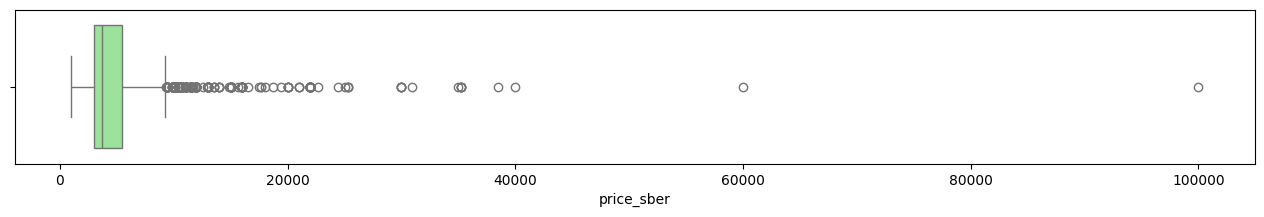

In [42]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors, x='price_sber',color = 'lightgreen')

рассмотрим без выбросов выше 3IQR

<Axes: xlabel='price_sber'>

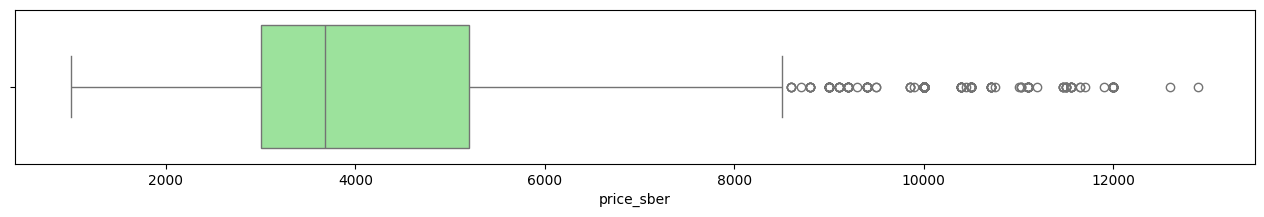

In [43]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors[doctors['price_sber'] < 3*IQR + Q3], x='price_sber',color='lightgreen')

Большинство цен лежат примерно в диапазоне 3000–5500

### prodoctorov

In [44]:
Q1 = doctors['price_prod'].quantile(0.25)
Q3 = doctors['price_prod'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
print(lower_whisker,upper_whisker)

-1100.0 9300.0


<Axes: xlabel='price_prod'>

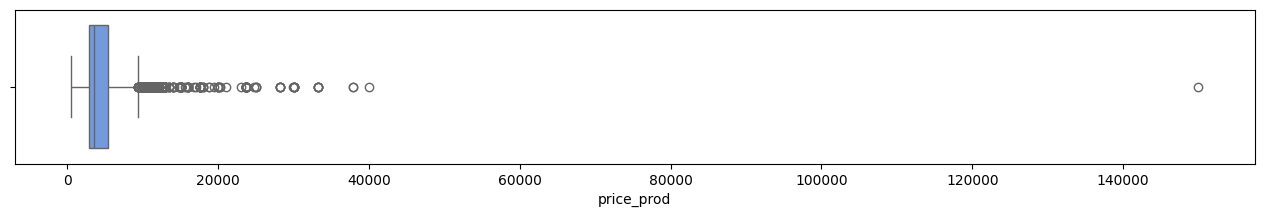

In [45]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors, x='price_prod', color='cornflowerblue')

аналогично рассмотрим значение < 3IQR

<Axes: xlabel='price_prod'>

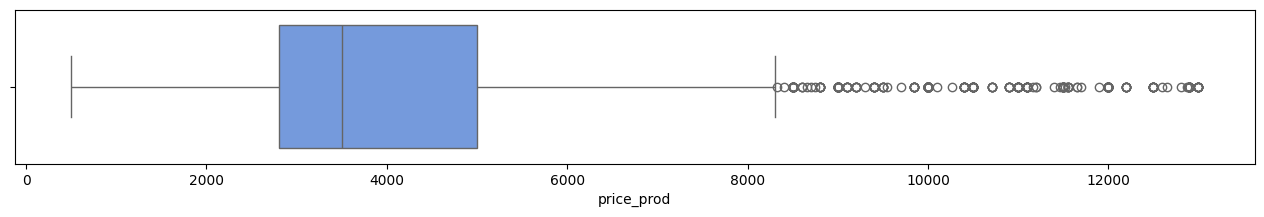

In [46]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors[doctors['price_prod'] < 3*IQR + Q3], x='price_prod',color='cornflowerblue')

Основной диапазон цен от 2800 до 5400 ₽, почти идентичен диапазону на Сбере 3000–5500.
Минимальные цены стартуют с 500, что говорит о наличии более дешёвых консультаций — возможно, молодых специалистов или скидок.

##cравнение цен для одних и тех же врачей на разных платформах

/tmp/ipython-input-4258261388.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


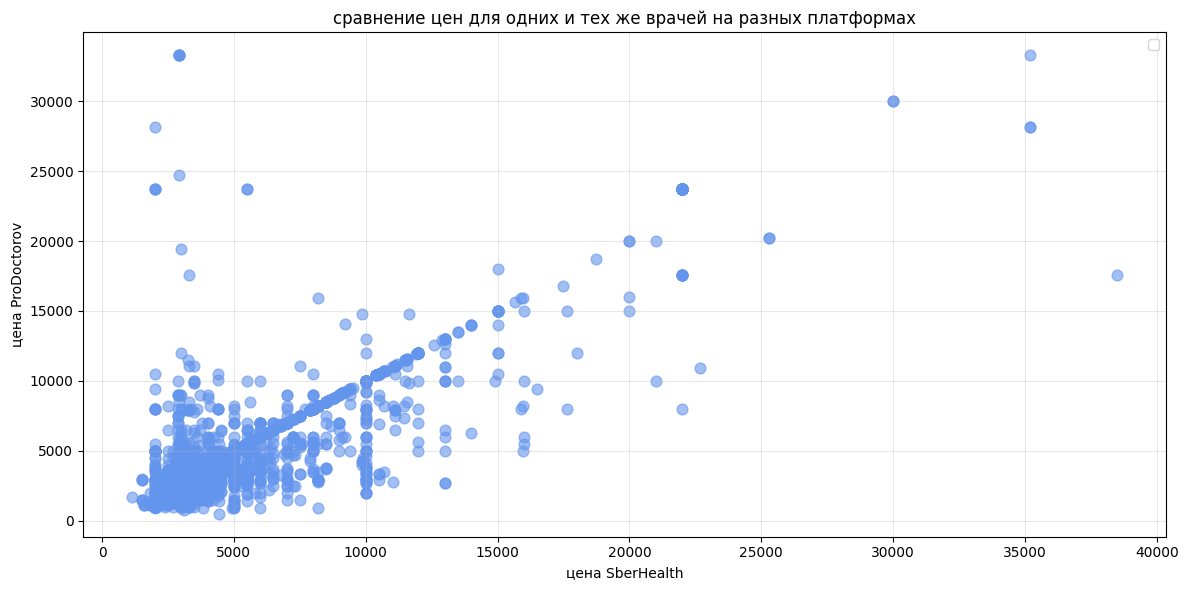

In [47]:
plt.figure(figsize=(12, 6))

doctors_platforms_with_price = doctors[
    (doctors['link_sber'].notna()) &
    (doctors['link_prod'].notna()) &
    (doctors['price_sber'].notna()) &
    (doctors['price_prod'].notna())]

plt.scatter(doctors_platforms_with_price['price_sber'], doctors_platforms_with_price ['price_prod'], alpha=0.6, color='cornflowerblue', s=60)
plt.title('cравнение цен для одних и тех же врачей на разных платформах')
plt.xlabel('цена SberHealth')
plt.ylabel('цена ProDoctorov')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Есть положительная зависимость, врачи сохраняют примерно одинаковый ценовой уровень на обеих площадках.

Но! Рассеивание большое
Видно множество точек, у которых цена на одной платформе выше, чем на другой. Часть врачей дифференцирует цены в зависимости от платформы — вероятно, по аудитории

In [48]:
corr = doctors_platforms_with_price['price_sber'].corr(doctors_platforms_with_price ['price_prod'])
corr

np.float64(0.7768772323962866)

цены и правда +- такие же, если, они, конечно, есть

##добавление столбца price

*у нас высокая корреляция у двух столбцов(никакой не является целевой переменной), тогда сделаем общий столбец

price = (price_sber+price_prod)/2*

In [49]:
doctors['price'] = (doctors['price_prod']+doctors['price_sber'])/2

In [50]:
doctors['price'].describe()

,price
count,2883.000000
mean,4855.611169
std,3394.128175
min,1360.000000
25%,2970.000000
50%,3700.000000
75%,5450.000000
max,34239.500000


In [51]:
Q1 = doctors['price'].quantile(0.25)
Q3 = doctors['price'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
print(lower_whisker,upper_whisker)

-750.0 9170.0


<Axes: xlabel='price'>

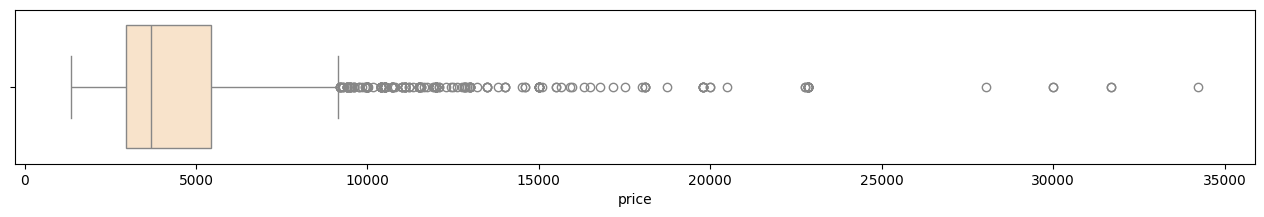

In [52]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors, x='price',color = 'bisque')

<Axes: xlabel='price'>

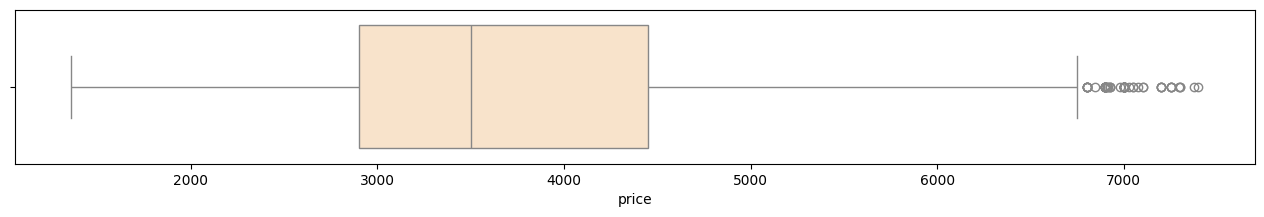

In [53]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors[doctors['price'] < 3*IQR], x='price',color = 'bisque')

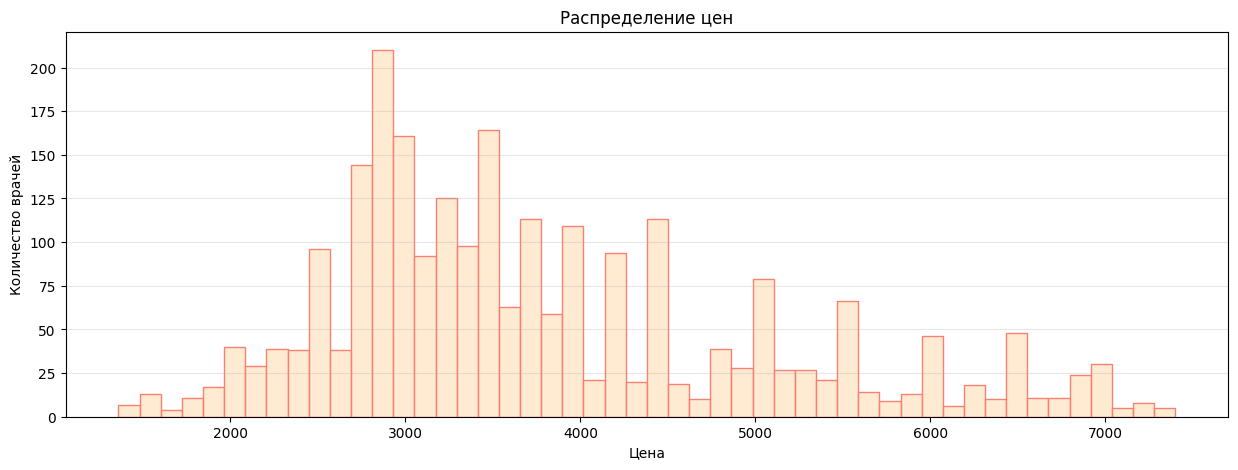

In [54]:
plt.figure(figsize=(15, 5))

sns.histplot(doctors[(doctors['price'].notna()) & (doctors['price'] < 3*IQR)]['price'],bins=50, color = 'bisque',edgecolor='salmon')
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Количество врачей')
plt.grid(alpha=0.3,axis='y')

##распределения цен на платформах

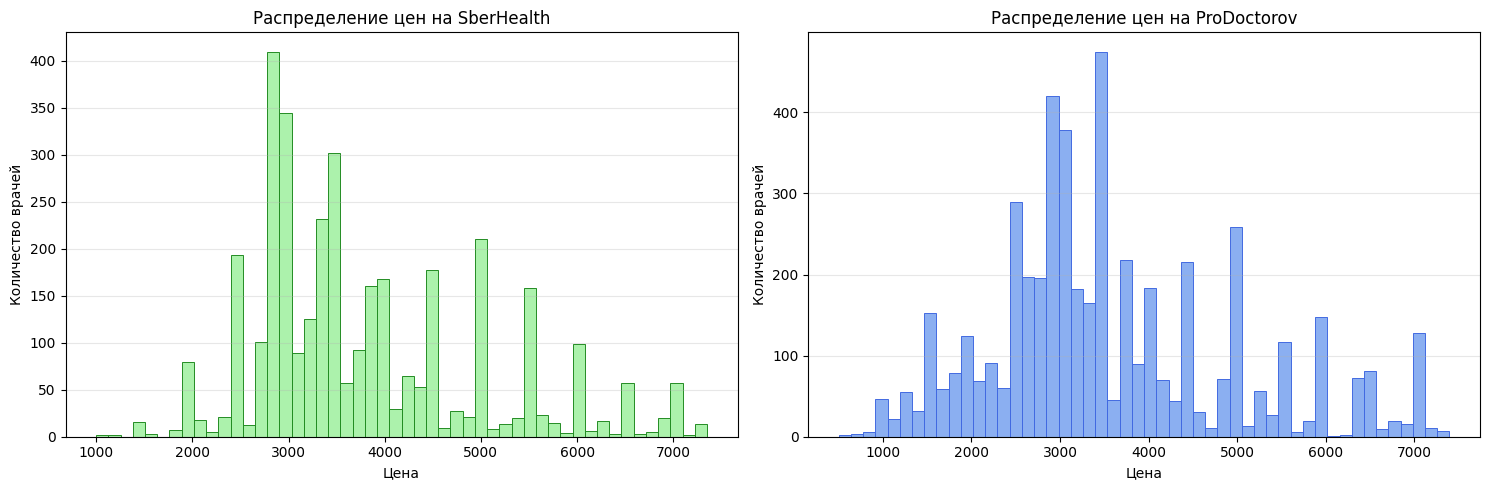

In [55]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(doctors[(doctors['price_sber'].notna()) & ((doctors['price_sber'] < 3*IQR))]['price_sber'],
             bins=50, color = 'lightgreen',edgecolor='forestgreen')
plt.title('Распределение цен на SberHealth')
plt.xlabel('Цена')
plt.ylabel('Количество врачей')
plt.grid(alpha=0.3,axis='y')

plt.subplot(1, 2, 2)
sns.histplot(doctors[(doctors['price_prod'].notna()) & (doctors['price_prod'] < 3*IQR)]['price_prod'],
             bins=50,color = 'cornflowerblue',edgecolor='royalblue')
plt.title('Распределение цен на ProDoctorov')
plt.xlabel('Цена')
plt.ylabel('Количество врачей')
plt.grid(alpha=0.3,axis='y')

plt.tight_layout()
plt.show()

##ценовые категории для sber, prodoctorov, AvgPrice

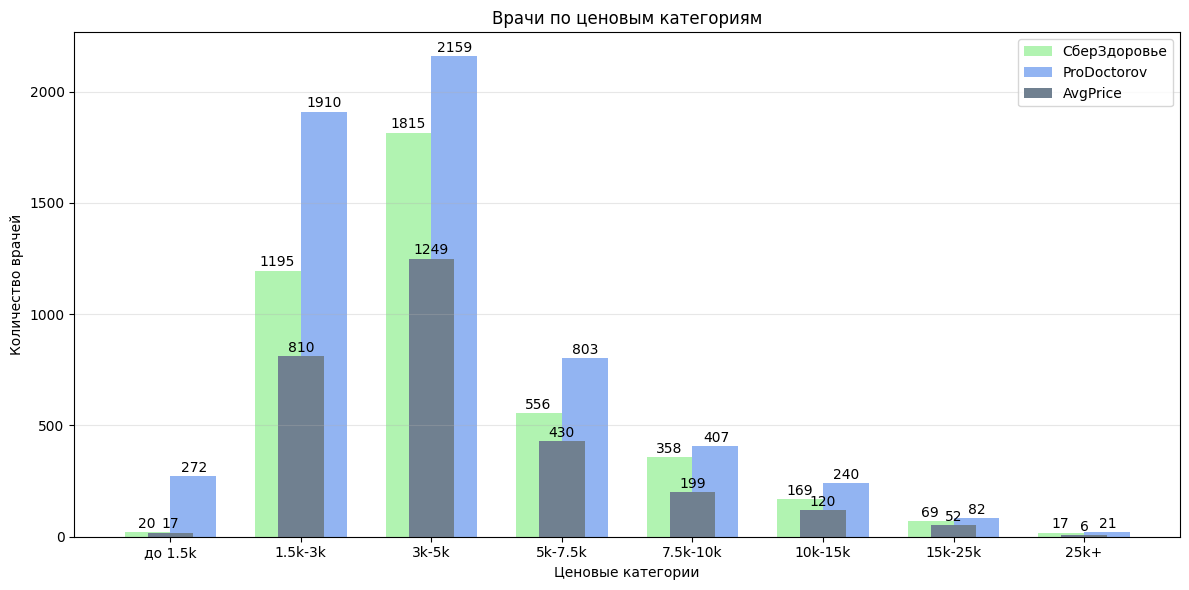

In [56]:
bins = [0, 1500, 3000, 5000, 7500, 10000, 15000, 25000, float('inf')]
labels = ['до 1.5k', '1.5k-3k', '3k-5k', '5k-7.5k', '7.5k-10k', '10k-15k', '15k-25k', '25k+']

doctors['price_category_sber'] = pd.cut(doctors['price_sber'], bins=bins, labels=labels)
doctors['price_category_prod'] = pd.cut(doctors['price_prod'], bins=bins, labels=labels)
doctors['price_category_avg'] = pd.cut(doctors['price'], bins=bins, labels=labels)

plt.figure(figsize=(12, 6))

sber_counts = doctors['price_category_sber'].value_counts().sort_index()
prod_counts = doctors['price_category_prod'].value_counts().sort_index()
price_counts = doctors['price_category_avg'].value_counts().sort_index()

x = np.arange(len(labels))
width = 0.35

bars1 = plt.bar(x - width/2, sber_counts, width, label='СберЗдоровье', alpha=0.7, color = 'lightgreen')
bars2 = plt.bar(x + width/2, prod_counts, width, label='ProDoctorov', alpha=0.7, color = 'cornflowerblue')
bars3 = plt.bar(x, price_counts, width, label='AvgPrice', color = 'slategrey')

for i, count in enumerate(sber_counts):
    plt.text(i-0.18, count + 20, str(count), ha='center')
for i, count in enumerate(prod_counts):
    plt.text(i+0.18, count + 20, str(count), ha='center')
for i, count in enumerate(price_counts):
    plt.text(i, count + 20, str(count), ha='center')

plt.xlabel('Ценовые категории')
plt.ylabel('Количество врачей')
plt.title('Врачи по ценовым категориям')
plt.xticks(x, labels)
plt.grid(alpha=0.3,axis='y')
plt.legend()
plt.tight_layout()
plt.show()


Основная масса рынка до 7.5k.

Больше 70 % врачей находятся в диапазоне 1.5k–5k

Категория 3k–5k ₽ — самая популярная:

Обе платформы наиболее насыщены врачами со средней ценой — конкуренция и выбор максимальны именно здесь.

Низкобюджетный сегмент почти отсутствует, что говорит о минимальном демпинге на рынке.

Дорогие приёмы редки — премиальный рынок ограничен, но вероятно ориентирован на центр города и узкие специальности

## зависимость цены от стажа по платформам

In [57]:
doctors[(doctors['doctor_source']=='SberHealth')][['experience','price_sber']].dropna().shape
doctors[(doctors['doctor_source']=='ProDoctorov')][['experience','price_prod']].dropna().shape


(71, 2)

у нас в датасете 71 врач у которых одновременно и опыт и цена указаны..

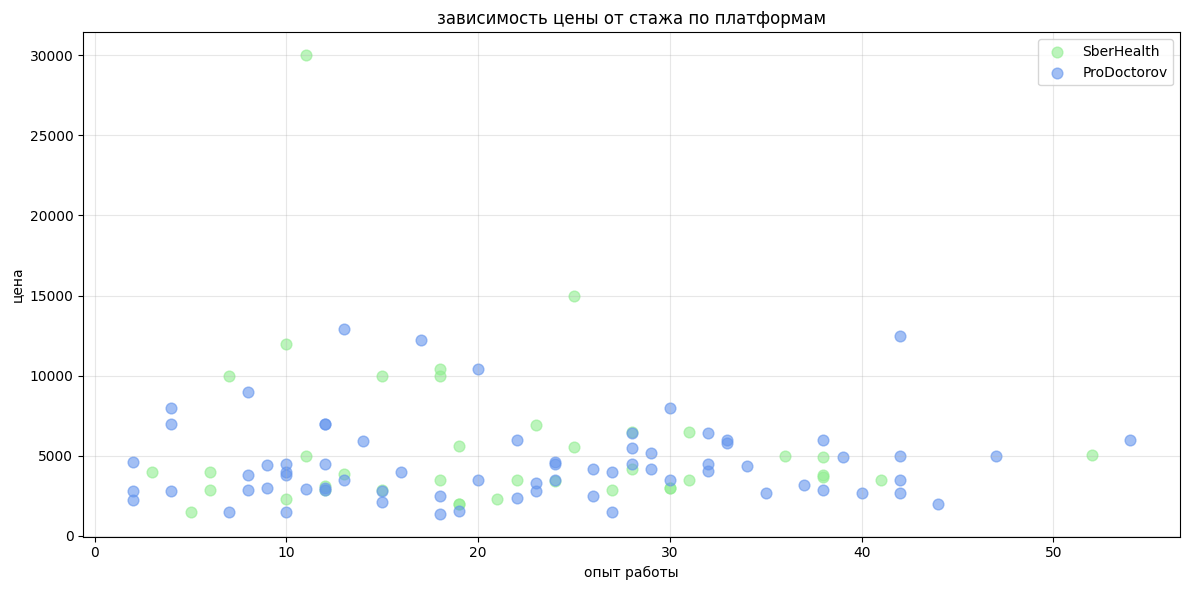

In [58]:
plt.figure(figsize=(12, 6))
plt.scatter(doctors[doctors['doctor_source']=='SberHealth']['experience'],
            doctors[doctors['doctor_source']=='SberHealth']['price_sber'], alpha=0.6, color='lightgreen', s=60, label='SberHealth')

plt.scatter(doctors[doctors['doctor_source']=='ProDoctorov']['experience'],
            doctors[doctors['doctor_source']=='ProDoctorov']['price_prod'], alpha=0.6, color='cornflowerblue', s=60, label='ProDoctorov')

plt.title('зависимость цены от стажа по платформам')
plt.xlabel('опыт работы')
plt.ylabel('цена')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
corr_sber = doctors[doctors['doctor_source']=='SberHealth']['experience'].corr(doctors[doctors['doctor_source']=='SberHealth']['price_sber'])
corr_prod = doctors[doctors['doctor_source']=='ProDoctorov']['experience'].corr(doctors[doctors['doctor_source']=='ProDoctorov']['price_prod'])
print(corr_sber,corr_prod)

-0.1461417124172429 0.05292339083254625


## сравнение средних цен по специальностям на разных платформах

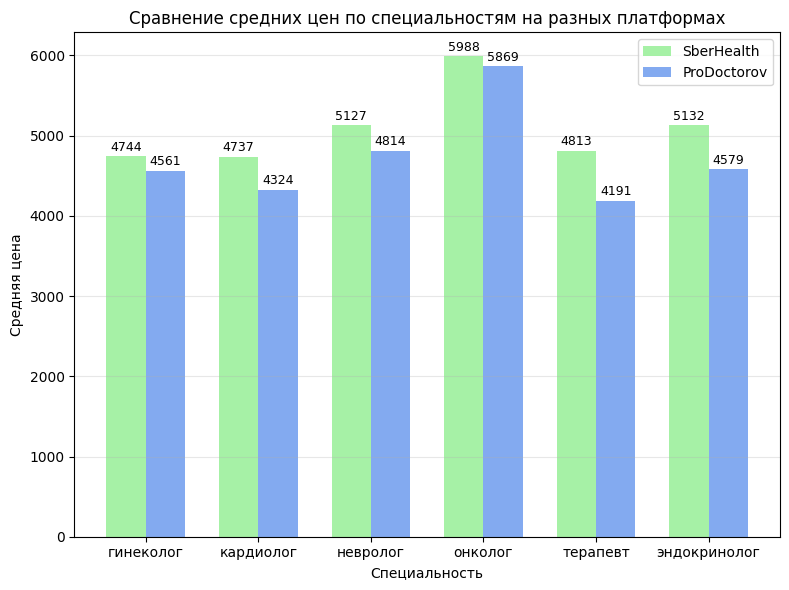

In [60]:
specialties = ['гинеколог', 'кардиолог', 'невролог', 'онколог', 'терапевт', 'эндокринолог']
avg_prices = pd.DataFrame(index=specialties, columns=['price_sber', 'price_prod'])

for specialty in specialties:
    specialty_doctors = doctors[doctors['speciality'].str.contains(specialty,na=False)]

    avg_sber = specialty_doctors['price_sber'].mean()
    avg_prices.loc[specialty, 'price_sber'] = avg_sber

    avg_prod = specialty_doctors['price_prod'].mean()
    avg_prices.loc[specialty, 'price_prod'] = avg_prod
avg_prices = avg_prices.astype(float)


plt.figure(figsize=(8, 6))
x = np.arange(len(specialties))
width = 0.35
plt.bar(x - width/2, avg_prices['price_sber'], width, label='SberHealth', alpha=0.8, color='lightgreen')
plt.bar(x + width/2, avg_prices['price_prod'], width, label='ProDoctorov', alpha=0.8, color='cornflowerblue')

plt.xlabel('Специальность')
plt.ylabel('Средняя цена')
plt.title('Сравнение средних цен по специальностям на разных платформах')
plt.xticks(x, specialties)
plt.legend()
plt.grid(axis='y', alpha=0.3)

for i in range(len(specialties)):
    sber_price = avg_prices['price_sber'].iloc[i]
    prod_price = avg_prices['price_prod'].iloc[i]
    plt.text(i - width/2, sber_price + 30, f'{sber_price:.0f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, prod_price + 30, f'{prod_price:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

СберЗдоровье дороже по всем специальностям


Онкологи — самые дорогие врачи на обеих платформах
Средняя цена около 6 000 ₽.
Редкая и высококвалифицированная категория, подтверждает премиум-сегмент.


Терапевты — самые доступные
На ПроДокторов — около 4 200 ₽, что на 30% ниже, чем у онкологов.


Разница между платформами стабильна по всем направлениям

## посмотрим на разницы в ценах:

In [61]:
price_diff = doctors_platforms_with_price['price_sber'] - doctors_platforms_with_price['price_prod']
price_diff.describe()

,0
count,2883.000000
mean,325.271592
std,2409.271925
min,-30379.000000
25%,0.000000
50%,0.000000
75%,885.000000
max,20900.000000


In [62]:
doctors_with_price_diff = doctors.copy()
doctors_with_price_diff['price_diff'] = abs(doctors_platforms_with_price['price_sber'] - doctors_platforms_with_price['price_prod']) # по модулю
doctors_with_price_diff['price_diff'].describe()

,price_diff
count,2883.000000
mean,1024.759625
std,2204.525541
min,0.000000
25%,0.000000
50%,210.000000
75%,1250.000000
max,30379.000000


среднее очень отличается от медианы

<Axes: xlabel='price_diff'>

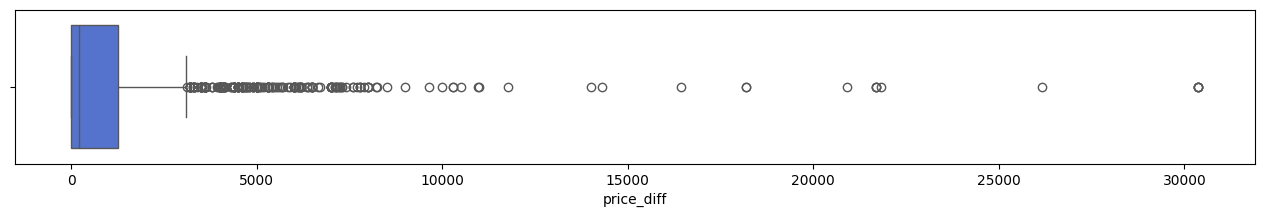

In [63]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors_with_price_diff, x='price_diff',color='royalblue')

<Axes: xlabel='price_diff', ylabel='Count'>

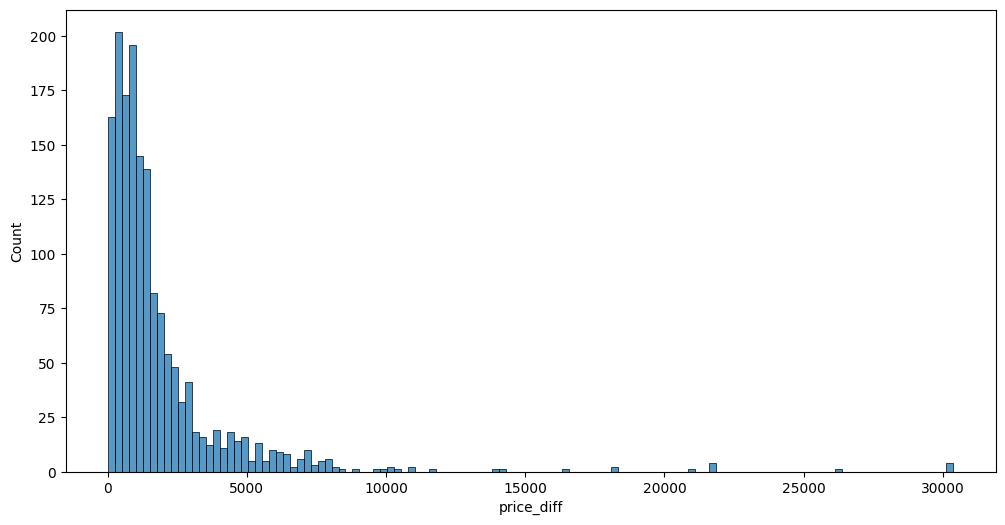

In [64]:
plt.figure(figsize=(12, 6))
sns.histplot(data=doctors_with_price_diff[doctors_with_price_diff['price_diff'] > 0], x='price_diff')

(0.0, 5695.4)

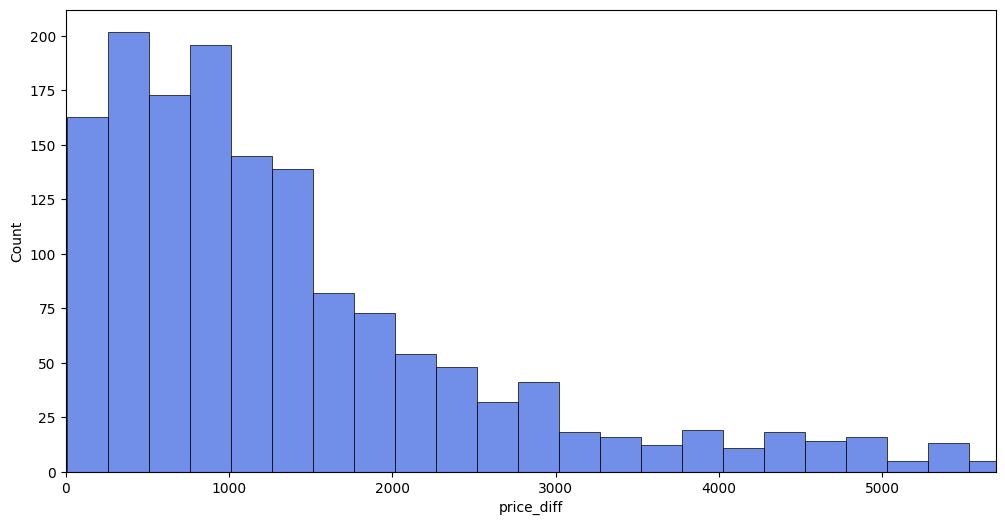

In [65]:
plt.figure(figsize=(12, 6))
sns.histplot(data=doctors_with_price_diff[doctors_with_price_diff['price_diff'] > 0], x='price_diff',color='royalblue')
plt.xlim(0, doctors_with_price_diff['price_diff'].quantile(0.97))

Пик в диапазоне 0–1000 ₽ — значит, у большинства врачей расхождение между Сбером и ПроДоктором минимальное, хвост доходит до 5–6 тыс., что всё ещё заметная разница. Распределение остается скошенным

Очень много выбросов. Оценим по верхнему усу и 3 IQR

In [66]:
q1 = doctors_with_price_diff['price_diff'].quantile(0.25)
q3 = doctors_with_price_diff['price_diff'].quantile(0.75)
iqr = q3 - q1

upper_whisker = q3 + 1.5 * iqr
upper_3iqr = q3 + 3 * iqr

print(upper_whisker, upper_3iqr, sep='\n')

3125.0
5000.0


In [67]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > upper_whisker].shape[0]

226

In [68]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > upper_3iqr].shape[0]

109

Посмотрим на те, где выбросы больше 3 IQR

In [69]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > upper_3iqr][['price_sber', 'price_prod', 'price_diff']]

,price_sber,price_prod,price_diff
503,10000.0,2000.0,8000.0
504,10000.0,2000.0,8000.0
859,10000.0,2900.0,7100.0
1466,10000.0,3500.0,6500.0
2262,7000.0,1500.0,5500.0
...,...,...,...
36085,9850.0,4000.0,5850.0
37168,13000.0,5000.0,8000.0
37600,8190.0,2900.0,5290.0
37846,2870.0,10000.0,7130.0


In [70]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > upper_3iqr][['price_sber', 'price_prod', 'price_diff']].describe()

,price_sber,price_prod,price_diff
count,109.000000,109.000000,109.000000
mean,9263.623853,9155.880734,8988.495413
std,7082.812460,8134.315486,5954.838382
min,2000.000000,900.000000,5060.000000
25%,3300.000000,3000.000000,6000.000000
50%,9850.000000,8000.000000,7000.000000
75%,10500.000000,10100.000000,8000.000000
max,38500.000000,33279.000000,30379.000000


В этих случаях в осеовном выше на сбере

In [71]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > q3 + 9*iqr][['price_sber', 'price_prod', 'price_diff']]

,price_sber,price_prod,price_diff
5228,2900.0,33279.0,30379.0
6396,2900.0,33279.0,30379.0
8554,5500.0,23694.0,18194.0
10288,2000.0,23694.0,21694.0
10954,5500.0,23694.0,18194.0
11580,22000.0,8000.0,14000.0
12858,2900.0,33279.0,30379.0
16167,3000.0,19425.0,16425.0
16729,3300.0,17600.0,14300.0
19934,2900.0,33279.0,30379.0


Для самых высоких значений разниц цен - очень высокие цены на Продокторов, в 13 из 15 случаев (отклонения выше 9 IQR)

## где цена выше для одних и тех же враче

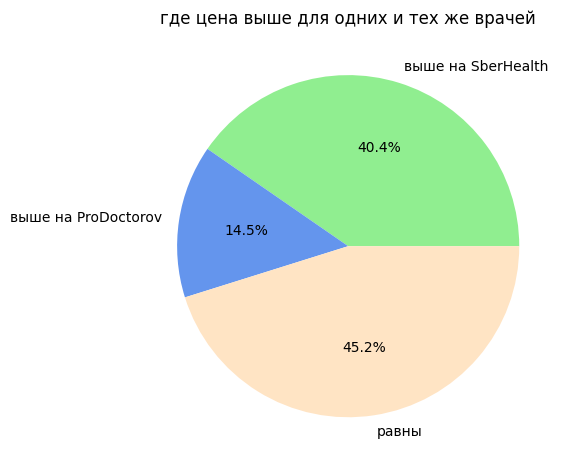

In [72]:
higher_sber = (price_diff > 0).sum()
higher_prod = (price_diff < 0).sum()
equal = (price_diff == 0).sum()

categories = ['выше на SberHealth', 'выше на ProDoctorov', 'равны']
values = [higher_sber, higher_prod, equal]
colors = ['lightgreen','cornflowerblue','bisque']
plt.pie(values, labels=categories, autopct='%1.1f%%',colors=colors)
plt.title('где цена выше для одних и тех же врачей')

plt.tight_layout()
plt.show()

In [73]:
corr = doctors_platforms_with_price['price_sber'].corr(doctors_platforms_with_price['price_prod'])
corr

np.float64(0.7768772323962866)

#Специальности (`'speciality'`)

In [74]:
doctors.columns

Index(['name', 'experience', 'rating_sber', 'review_count_sber', 'price_sber',
       'link_sber', 'clinics_count_sber', 'clinic_1_name_sber',
       'clinic_1_address_sber', 'clinic_1_metro_sber', 'clinic_2_name_sber',
       'clinic_2_address_sber', 'clinic_2_metro_sber', 'clinic_3_name_sber',
       'clinic_3_address_sber', 'clinic_3_metro_sber', 'link_prod',
       'price_prod', 'rating_prod', 'review_count_prod', 'clinics_count_prod',
       'clinic_1_name_prod', 'clinic_1_address_prod', 'clinic_1_metro_prod',
       'clinic_2_name_prod', 'clinic_2_address_prod', 'clinic_2_metro_prod',
       'clinic_3_name_prod', 'clinic_3_address_prod', 'clinic_3_metro_prod',
       'speciality', 'is_kids', 'is_adults', 'doctor_source',
       'experience_category', 'price', 'price_category_sber',
       'price_category_prod', 'price_category_avg'],
      dtype='object')

In [75]:
def speciality_to_string(spec_list):
    if pd.isna(spec_list):
        return None
    if isinstance(spec_list, str):
        try:
            spec_list = eval(spec_list)
        except:
            return spec_list
    if isinstance(spec_list, list):
        return ', '.join(spec_list)
    return str(spec_list)
doctors['speciality'] = doctors['speciality'].apply(speciality_to_string)

In [76]:
doctors['speciality']

,speciality
0,терапевт
1,терапевт
2,None
3,None
4,None
...,...
38860,"акушер, детский гинеколог, гинеколог"
38861,"реабилитолог, невролог"
38862,"остеопат, терапевт"
38863,"акушер, гинеколог-хирург, гинеколог"


In [77]:
doctors['speciality'].unique()

array(['терапевт', None,
       'детский невролог, детский эпилептолог, невролог', ...,
       'функциональный диагност, детский невролог, детский эпилептолог',
       'аллерголог, детский пульмонолог, функциональный диагност, терапевт, пульмонолог',
       'акушер, онколог-гинеколог, гинеколог-эндокринолог, врач узи, нутрициолог, репродуктолог, диетолог, гинеколог'],
      dtype=object)

In [78]:
all_individual_specs = []
for spec_str in doctors['speciality'].dropna():
    specs = spec_str.split(', ')
    all_individual_specs.extend(specs)

individual_spec_counts = pd.Series(all_individual_specs).value_counts()

In [79]:
individual_spec_counts.sample(10)

,count
детский отоневролог,3
детский травматолог,5
эндоскопист,49
акушер,3763
онколог-уролог,35
врач общей практики (семейный врач),390
детский мануальный терапевт,23
детский флеболог,3
детский аллерголог,14
детский генетик,2


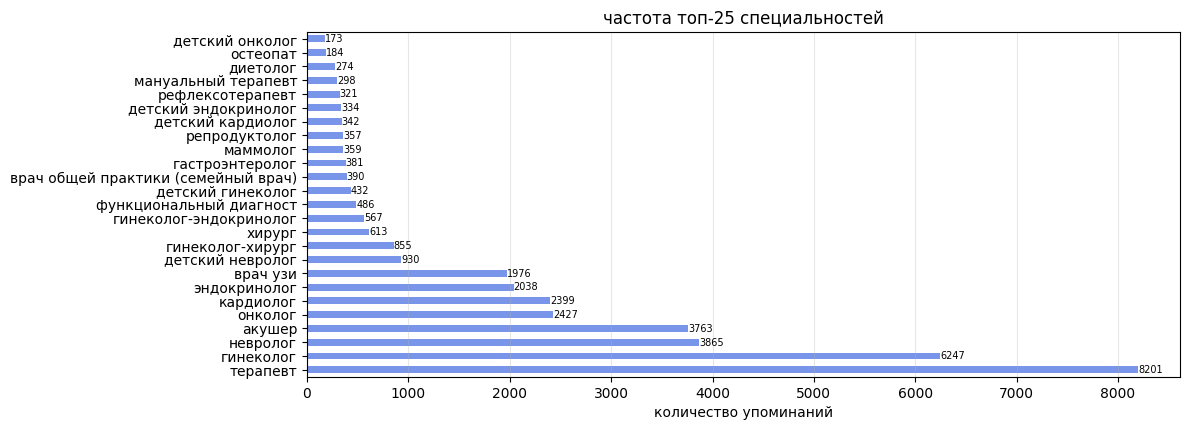

In [80]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
top_25_specs = individual_spec_counts.head(25)
top_25_specs.plot(kind='barh', alpha=0.7,color='royalblue')
plt.title('частота топ-25 специальностей')
plt.xlabel('количество упоминаний')
plt.grid(axis='x', alpha=0.3)

for i, count in enumerate(top_25_specs.values):
    plt.text(count, i, str(count), va='center', fontsize=7)

plt.tight_layout()
plt.show()

## популярные специальности среди терапевтов

In [81]:
terapevts = doctors[doctors['speciality'].str.contains('терапевт', case=False, na=False)]

terapevt_individual_specs = []
for spec_str in terapevts['speciality'].dropna():
    specs = spec_str.split(', ')
    terapevt_individual_specs.extend(specs)

terapevt_spec_counts = pd.Series(terapevt_individual_specs).value_counts()

In [82]:
terapevt_spec_counts.head(20)

,count
терапевт,8201
невролог,600
кардиолог,569
гастроэнтеролог,375
врач общей практики (семейный врач),362
рефлексотерапевт,321
мануальный терапевт,298
врач узи,174
функциональный диагност,159
онколог,159


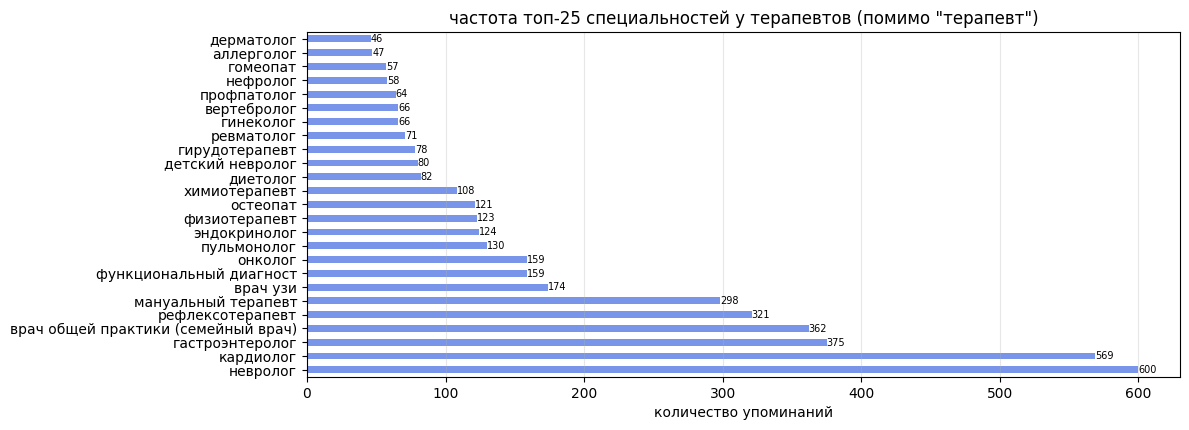

In [83]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
top_25_specs = terapevt_spec_counts[1:26]
top_25_specs.plot(kind='barh', alpha=0.7,color='royalblue')
plt.title('частота топ-25 специальностей у терапевтов (помимо "терапевт")')
plt.xlabel('количество упоминаний')
plt.grid(axis='x', alpha=0.3)

for i, count in enumerate(top_25_specs.values):
    plt.text(count, i, str(count), va='center', fontsize=7)

plt.tight_layout()
plt.show()

#Детские и взрослые врачи (`kids/adults`)

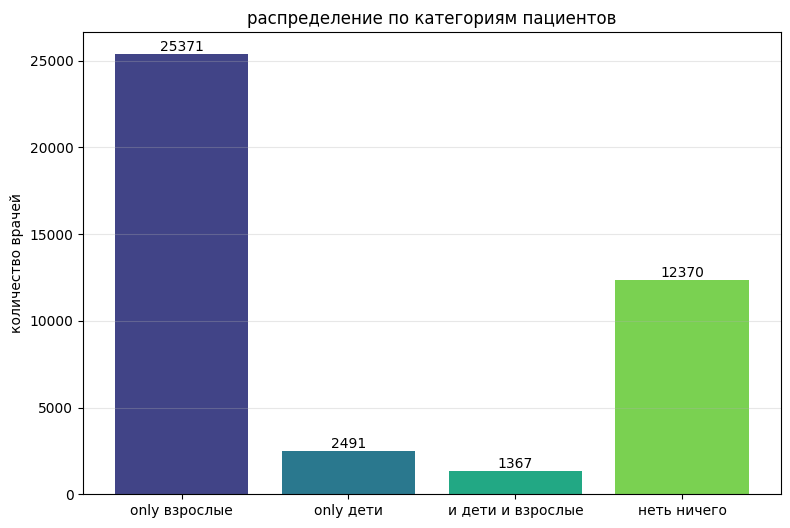

In [84]:
plt.figure(figsize=(9, 6))

categories_count = {
    'only взрослые': doctors['is_adults'].sum(),
    'only дети': doctors['is_kids'].sum(),
    'и дети и взрослые': ((doctors['is_adults'] == True) & (doctors['is_kids'] == True)).sum(),
    'неть ничего': ((doctors['is_adults'] == False) & (doctors['is_kids'] == False)).sum()}

colors = sns.color_palette("viridis", len(categories_count))
plt.bar(categories_count.keys(), categories_count.values(),color=colors)
plt.title('распределение по категориям пациентов')
plt.ylabel('количество врачей')
plt.grid(axis='y', alpha=0.3)

for i, count in enumerate(categories_count.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

### Разобьем специальности на разные строки

In [106]:
def to_list(text):
    if pd.isna(text):
        return []
    return [t.strip() for t in str(text).split(',') if t.strip()]

In [107]:
new_df = doctors.copy()
new_df['speciality'] = new_df['speciality'].apply(to_list)

### Исследуем ко-встречаемость специальностей

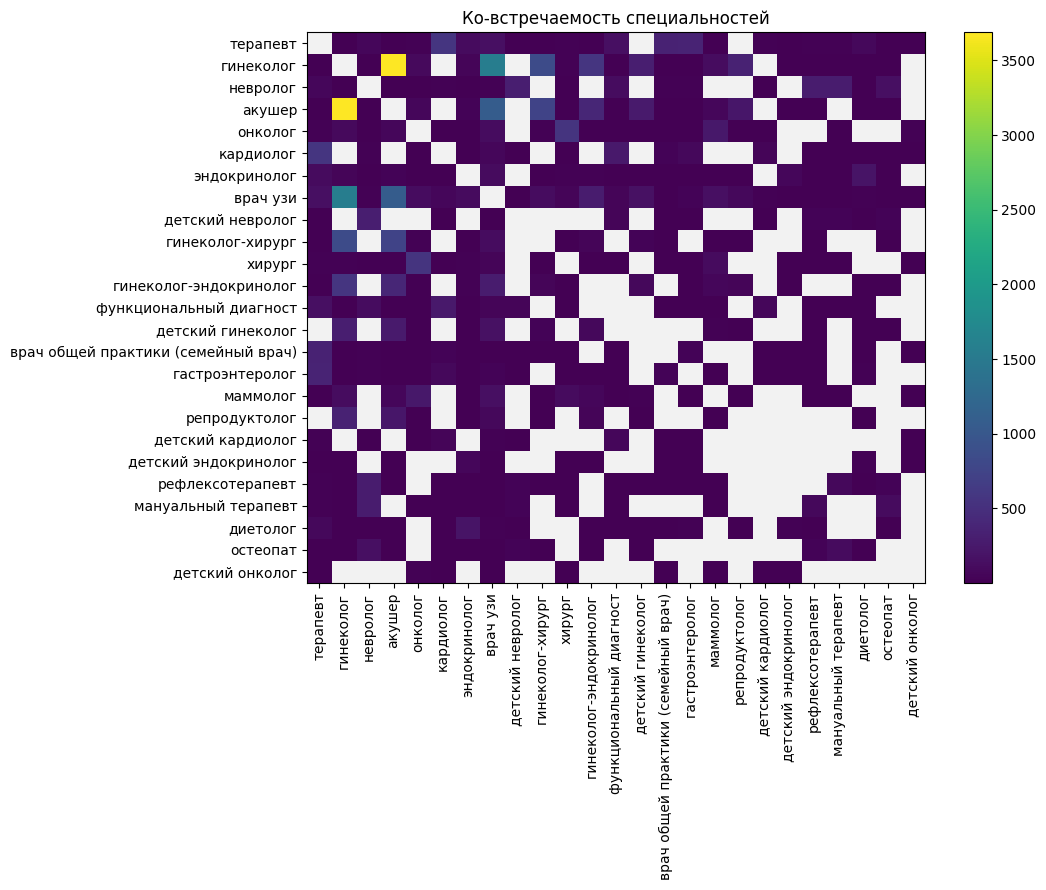

In [108]:
flat = [sp for L in new_df["speciality"] for sp in L] # берём каждую строку (L — это список спец. врача) и из каждого такого списка берём каждую спец. (sp). В итоге flat — это один длинный список всех спец. по всем врачам
vc = pd.Series(flat).value_counts() # считаем, сколько раз каждая спец. встречается. получаем частоты по всем спец.

TOPN = 25 # берем только 25 самых популярных специальностей
topN = vc.head(TOPN).index # получаем эти специальности

# специальный счётчик из модуля collections. он ведёт частоты объектов как словарь: ключ -> сколько раз встретился
pair_counter = Counter() # сколько раз встретилась каждая спец.

for L in new_df["speciality"]:
    S = [sp for sp in L if sp in topN] # оставляем только те спец. этого врача, которые входят в наш топ-25
    if not S:
        continue
    S = sorted(set(S)) # set(S), чтобы внутри одной строки не учитьывать два раза одну и ту же специальность. сортируем для того, чтобы был единый лексикографический порядок
    for a, b in combinations(S, 2): # берем все комбинации по 2
        pair_counter[(a,b)] += 1
        pair_counter[(b,a)] += 1 # делаем матрицу симметричной

C = pd.DataFrame(0, index=topN, columns=topN, dtype=int) # создаём квадратную таблицу, всю забитую нулями
for (a,b), c in pair_counter.items():
    C.loc[a,b] = c # заполняем ячейки числами«сколько раз пара (a,b) встретилась у врачей
np.fill_diagonal(C.values, 0) # чтобы не сбивать с толку на диагонали поставим значение 0

masked = np.ma.masked_where(C.to_numpy() == 0, C.to_numpy()) # всё, где матрица C равна нулю, помечаем как маску (невидимые значения)
cmap = plt.cm.viridis.copy() # берем копию колормэпа viridis, чтобы можно было менять его свойства не трогая глобальный)
cmap.set_bad('#f2f2f2') # так рисуем нули

fig, ax = plt.subplots(figsize=(11, 9))
im = ax.imshow(masked, cmap=cmap, aspect="auto", vmin=1, vmax=C.values.max()) # разрешаем оси растягиваться по размеру фигуры, нижняя граница шкалы = 1, чтобы 0 точно не окрашивался как данные, верхняя граница шкалы = максимум в C
ax.set_xticks(range(C.shape[1])); ax.set_yticks(range(C.shape[0])) # ставим подписи на каждую колонку и строку матрицы
ax.set_xticklabels(C.columns, rotation=90); ax.set_yticklabels(C.index) # подписываем их значения
ax.set_title(f"Ко-встречаемость специальностей")
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [109]:
new_df = new_df.explode('speciality')
new_df

,name,experience,rating_sber,review_count_sber,price_sber,link_sber,clinics_count_sber,clinic_1_name_sber,clinic_1_address_sber,clinic_1_metro_sber,...,clinic_3_metro_prod,speciality,is_kids,is_adults,doctor_source,experience_category,price,price_category_sber,price_category_prod,price_category_avg
0,Абросимова Елена Владимировна,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,терапевт,False,True,ProDoctorov,21-30 лет,NaN,NaN,NaN,NaN
1,Абросимова Елена Владимировна,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,терапевт,False,True,ProDoctorov,Более 30 лет,NaN,NaN,NaN,NaN
2,Агеева Наталья Юрьевна,18.0,4.5,0.0,3500.0,https://docdoc.ru/doctor/Ageeva_Natalya_12,1.0,Будь Здоров на Рязанском проспекте,"г. Москва, ул. Рязанский пр-т, д. 2Б",Нижегородская,...,NaN,NaN,False,True,SberHealth,16-20 лет,NaN,3k-5k,NaN,NaN
3,Агеева Наталья Юрьевна,NaN,4.0,0.0,NaN,https://docdoc.ru/doctor/Ageeva_Natalya_3,0.0,NaN,NaN,NaN,...,NaN,NaN,False,False,SberHealth,No value,NaN,NaN,NaN,NaN
4,Акимова Анна Владимировна,18.0,4.3,0.0,NaN,https://docdoc.ru/doctor/Akimova_Anna_7,0.0,NaN,NaN,NaN,...,NaN,NaN,False,False,SberHealth,16-20 лет,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38862,Ящина Ольга Владимировна,NaN,4.0,3.0,NaN,https://docdoc.ru/doctor/Yashtina_Olga,0.0,NaN,NaN,NaN,...,NaN,терапевт,False,True,Обе платформы,No value,NaN,NaN,NaN,NaN
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,акушер,False,True,Обе платформы,Более 30 лет,NaN,NaN,NaN,NaN
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,гинеколог-хирург,False,True,Обе платформы,Более 30 лет,NaN,NaN,NaN,NaN
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,гинеколог,False,True,Обе платформы,Более 30 лет,NaN,NaN,NaN,NaN


Удалим словой 'детский' из специальностей и пометим is_kids = True, если встретили такой случай. Также флаг помечаем 1, если встретили слово 'педиатр', но не удаляем его

In [110]:
KIDS_ADJ_RE = re.compile(r"\b(детск\w*|педиатрическ\w*)\b", flags=re.IGNORECASE) # компилируем объект регулярного выражения для последующего использования, игнорируем регистр
PEDIATR_ONLY_RE = re.compile(r"\bпедиатр\b", flags=re.IGNORECASE)

def clean_kids_flag(spec: str):
    if not isinstance(spec, str): # если каким-то образом в функцию попало не строковое значение (например NaN), просто возвращаем как есть и is_kids=False
        return spec, False

    s = spec.strip()
    has_kids_adj = bool(KIDS_ADJ_RE.search(s)) # если нашли нашу регулярку, то флаг принимает значение True
    has_pediatr = bool(PEDIATR_ONLY_RE.search(s)) # если нашли нашу регулярку, то флаг принимает значение True

    # вырезаем только прилагательные-маркеры, просто педиатров не трогаем
    if has_kids_adj:
        s = KIDS_ADJ_RE.sub("", s) # если нашли прилагательные-маркеры (из первого флага), вырезаем их из названия специальности

    # чистим дефисы/тире и лишние пробелы, которые могли остаться, убираем висячие дефисы вокруг мест вырезки
    s = re.sub(r"\s{2,}", " ", s).strip(" ,.;-–—")

    is_kids = has_kids_adj or has_pediatr

    return s, is_kids

new_df[["speciality", "is_kids"]] = (new_df["speciality"].apply(clean_kids_flag).apply(pd.Series))
new_df["is_kids"] = new_df["is_kids"].astype(bool)

In [111]:
new_df

,name,experience,rating_sber,review_count_sber,price_sber,link_sber,clinics_count_sber,clinic_1_name_sber,clinic_1_address_sber,clinic_1_metro_sber,...,clinic_3_metro_prod,speciality,is_kids,is_adults,doctor_source,experience_category,price,price_category_sber,price_category_prod,price_category_avg
0,Абросимова Елена Владимировна,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,терапевт,False,True,ProDoctorov,21-30 лет,NaN,NaN,NaN,NaN
1,Абросимова Елена Владимировна,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,терапевт,False,True,ProDoctorov,Более 30 лет,NaN,NaN,NaN,NaN
2,Агеева Наталья Юрьевна,18.0,4.5,0.0,3500.0,https://docdoc.ru/doctor/Ageeva_Natalya_12,1.0,Будь Здоров на Рязанском проспекте,"г. Москва, ул. Рязанский пр-т, д. 2Б",Нижегородская,...,NaN,NaN,False,True,SberHealth,16-20 лет,NaN,3k-5k,NaN,NaN
3,Агеева Наталья Юрьевна,NaN,4.0,0.0,NaN,https://docdoc.ru/doctor/Ageeva_Natalya_3,0.0,NaN,NaN,NaN,...,NaN,NaN,False,False,SberHealth,No value,NaN,NaN,NaN,NaN
4,Акимова Анна Владимировна,18.0,4.3,0.0,NaN,https://docdoc.ru/doctor/Akimova_Anna_7,0.0,NaN,NaN,NaN,...,NaN,NaN,False,False,SberHealth,16-20 лет,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38862,Ящина Ольга Владимировна,NaN,4.0,3.0,NaN,https://docdoc.ru/doctor/Yashtina_Olga,0.0,NaN,NaN,NaN,...,NaN,терапевт,False,True,Обе платформы,No value,NaN,NaN,NaN,NaN
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,акушер,False,True,Обе платформы,Более 30 лет,NaN,NaN,NaN,NaN
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,гинеколог-хирург,False,True,Обе платформы,Более 30 лет,NaN,NaN,NaN,NaN
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,гинеколог,False,True,Обе платформы,Более 30 лет,NaN,NaN,NaN,NaN


## Топ-20 врачей (учитываются только врачи для взрослых)

In [112]:
adults_df = new_df[new_df['is_adults'] == True]

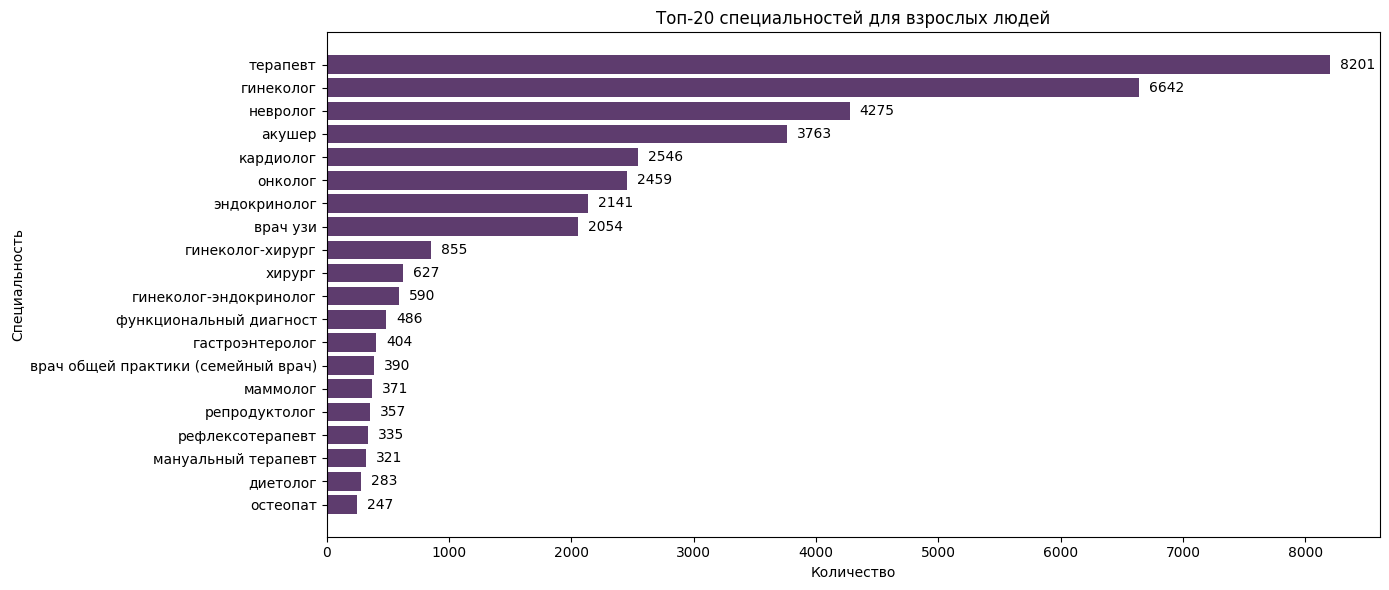

In [113]:
counts = (adults_df['speciality'].dropna().value_counts().head(20)) # считаем, сколько раз встречается каждая специальность, берём топ-20 самых частых

counts = counts.sort_values(ascending=True) # сортируем по возрастанию
fig, ax = plt.subplots(figsize=(14, 6))
ax.barh(counts.index, counts.values, color= '#5e3c6e')

for y, v in enumerate(counts.values): # проходим по всем столбцам. y - номер строки (позиция по вертикали), v — значение (длина столбика)
    ax.text(v + max(counts.values)*0.01, y, str(v), va="center") # рисуем подпись с числом справа от столбика. v + max(counts.values)*0.01 — текст чуть правее конца столбика. y — вертикальная позиция подписи ровно напротив столбика. va="center" — выравнивание текста по вертикали по центру столбика

ax.set_xlabel('Количество')
ax.set_ylabel('Специальность')
ax.set_title('Топ-20 специальностей для взрослых людей')

plt.tight_layout()
plt.show()

## Топ-20 врачей (учитываются толькое детские)

In [114]:
kids_df = new_df[new_df['is_kids'] == True]

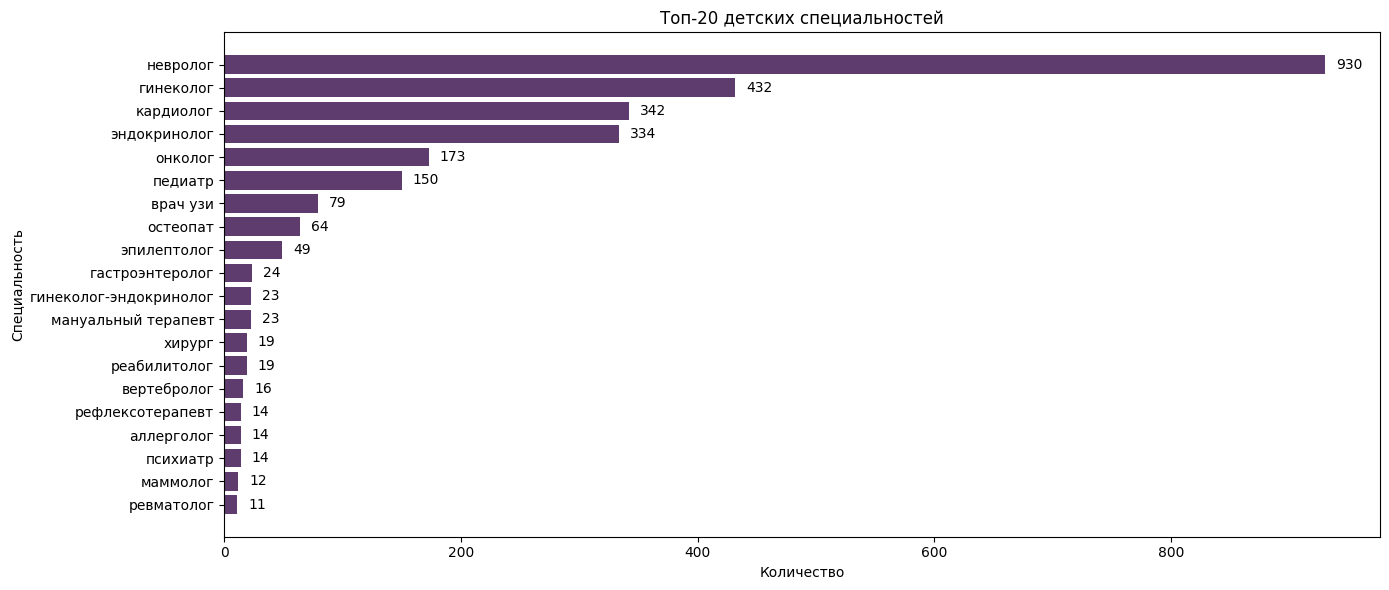

In [115]:
counts = (kids_df['speciality'].dropna().value_counts().head(20)) # считаем, сколько раз встречается каждая специальность, берём топ-20 самых частых

counts = counts.sort_values(ascending=True) # сортируем по возрастанию
fig, ax = plt.subplots(figsize=(14, 6))
ax.barh(counts.index, counts.values, color= '#5e3c6e')

for y, v in enumerate(counts.values): # проходим по всем столбцам. y - номер строки (позиция по вертикали), v — значение (длина столбика)
    ax.text(v + max(counts.values)*0.01, y, str(v), va="center") # рисуем подпись с числом справа от столбика. v + max(counts.values)*0.01 — текст чуть правее конца столбика. y — вертикальная позиция подписи ровно напротив столбика. va="center" — выравнивание текста по вертикали по центру столбика

ax.set_xlabel('Количество')
ax.set_ylabel('Специальность')
ax.set_title('Топ-20 детских специальностей')

plt.tight_layout()
plt.show()

## Топ-30 редких специальностей среди взрослых

In [116]:
freq = adults_df['speciality'].value_counts() # считаем частоту встречаний каждого значения
freq_sorted = freq.sort_values(ascending=False) # сортируем по убыванию
rare = freq[freq <= 10].sort_values(ascending=True) # считаем редкими тех, кто встречается не более 10 раз

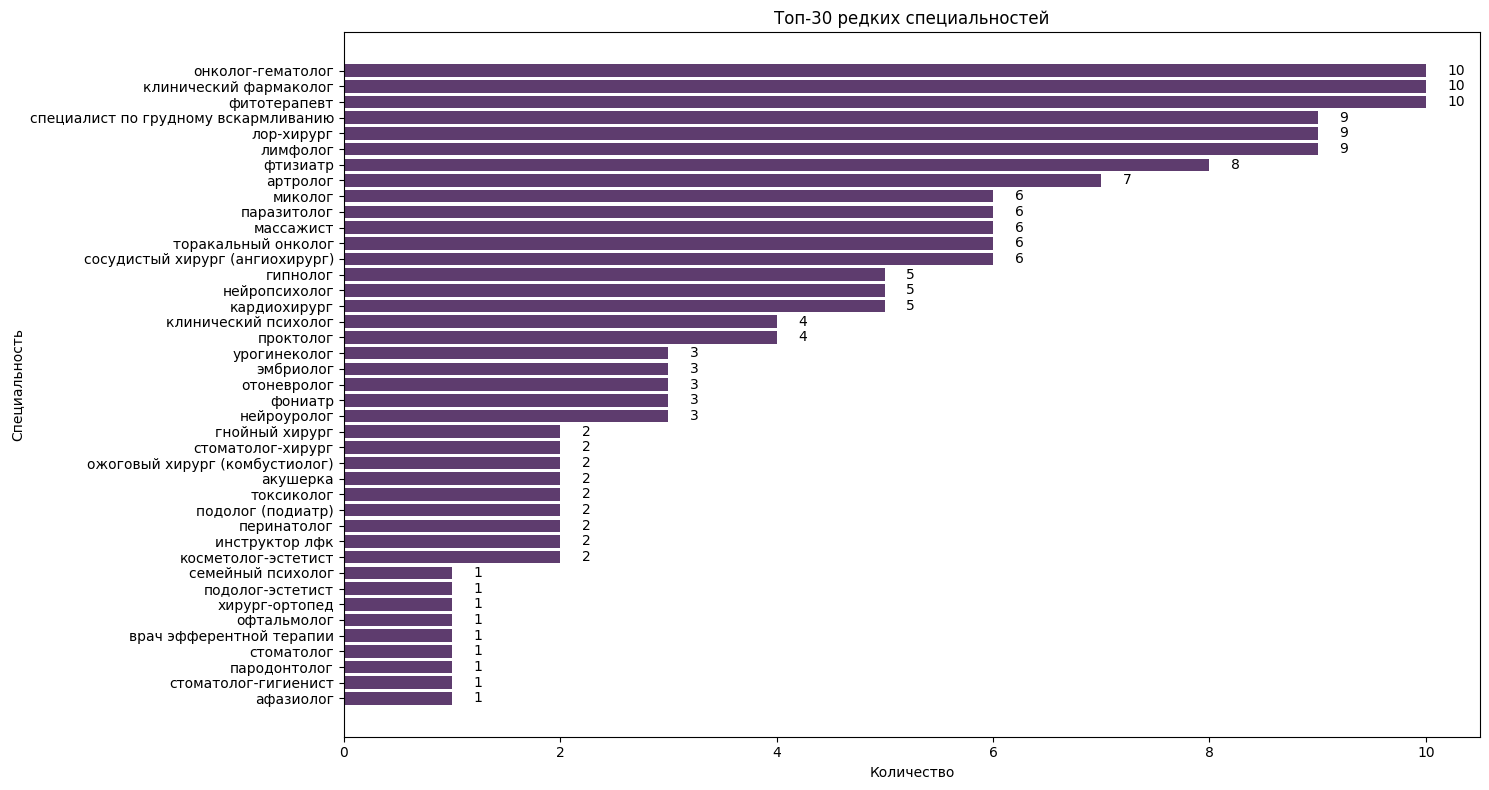

In [117]:
plt.figure(figsize=(15, 8))
plt.barh(rare.index, rare.values, color= '#5e3c6e')

for y, v in enumerate(rare.values):
    plt.text(v + (rare.values.max()*0.02 if rare.values.max()>0 else 0.1), y, str(v), va="center")

plt.xlabel("Количество")
plt.ylabel("Специальность")
plt.title("Топ-30 редких специальностей")

plt.tight_layout()
plt.show()

## Топ-30 редких специальностей среди детей

In [118]:
freq = kids_df['speciality'].value_counts() # считаем частоту встречаний каждого значения
freq_sorted = freq.sort_values(ascending=False) # сортируем по убыванию
rare = freq[freq <= 10].sort_values(ascending=True) # считаем редкими тех, кто встречается не более 10 раз

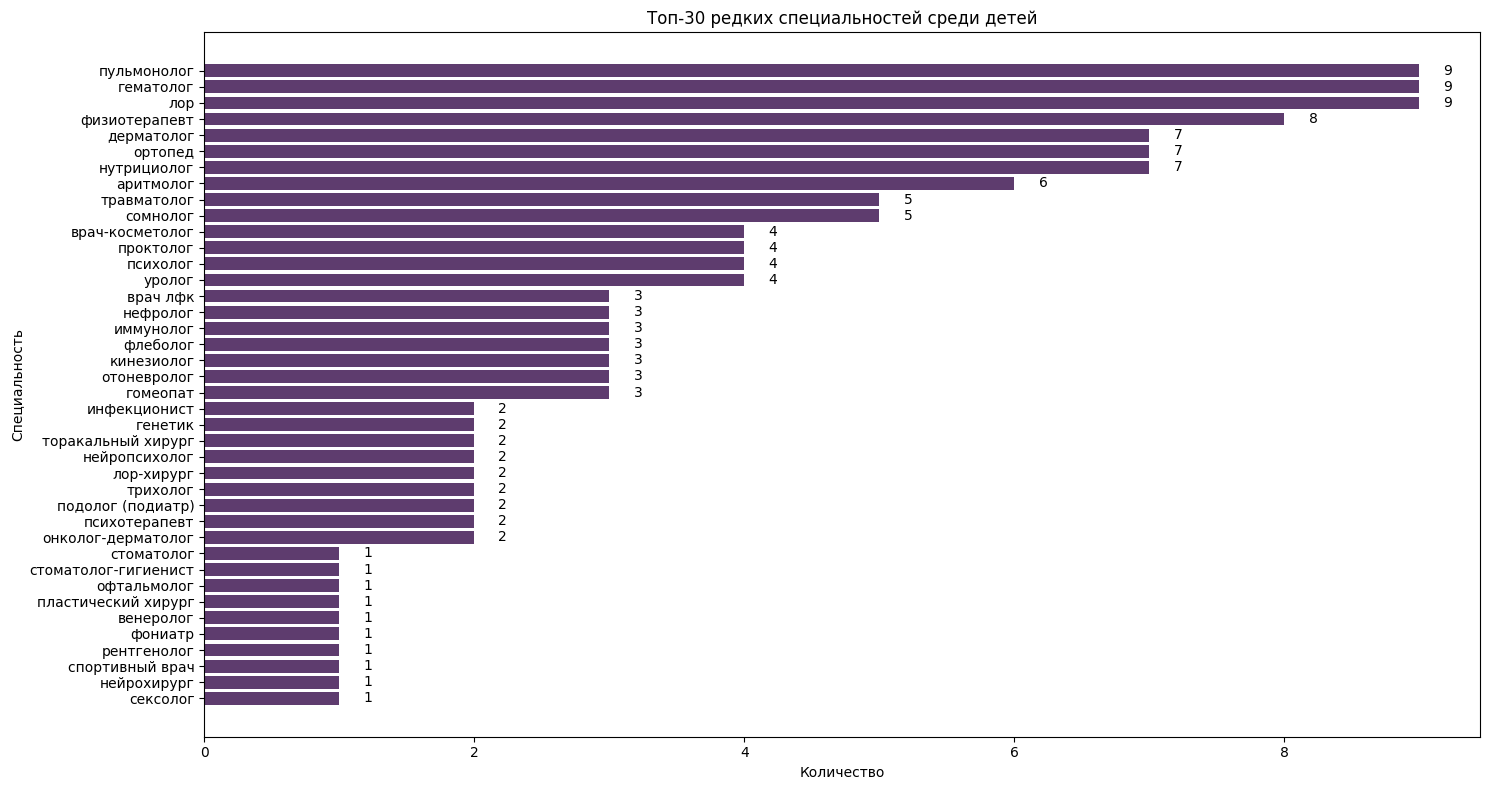

In [119]:
plt.figure(figsize=(15, 8))
plt.barh(rare.index, rare.values, color= '#5e3c6e')

for y, v in enumerate(rare.values):
    plt.text(v + (rare.values.max()*0.02 if rare.values.max()>0 else 0.1), y, str(v), va="center")

plt.xlabel("Количество")
plt.ylabel("Специальность")
plt.title("Топ-30 редких специальностей среди детей")

plt.tight_layout()
plt.show()

## Доли детских врачей

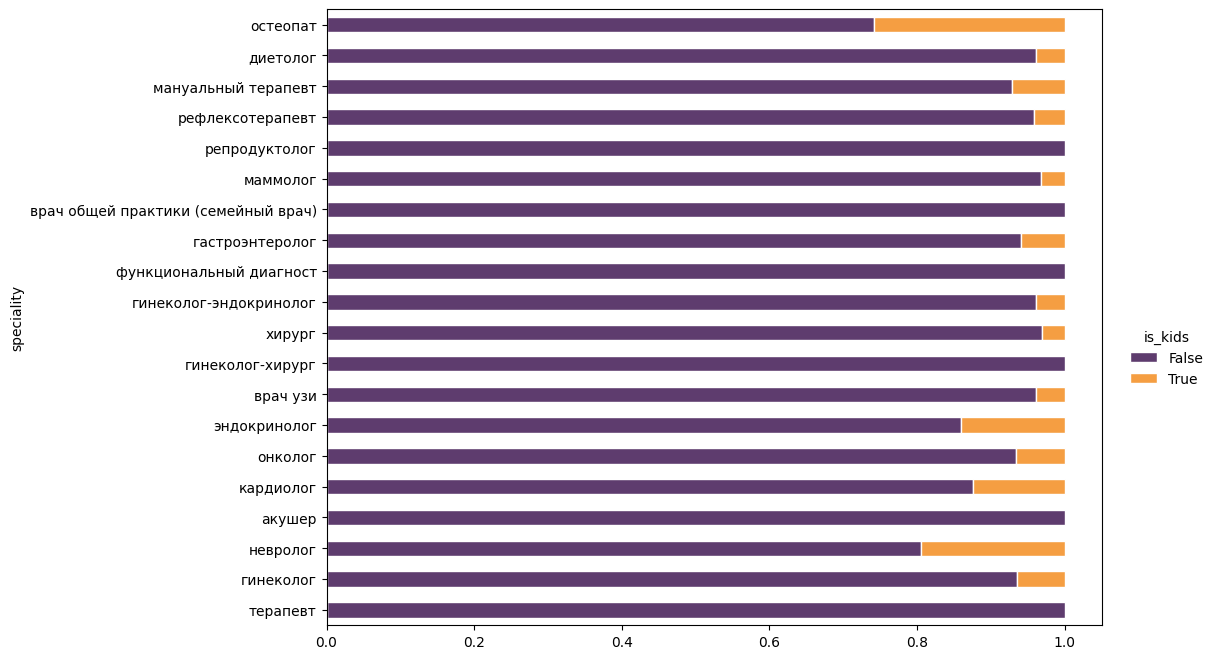

In [120]:
ct = pd.crosstab(new_df["speciality"], new_df["is_kids"]) # строим перекрёстную таблицу
colors = ["#5e3c6e", "#f59e42"]

share = ct.div(ct.sum(1), axis=0).loc[ct.sum(1).nlargest(20).index] # делим каждую строку ct на её собственную сумму, берём индексы топ-20 самых многочисленных специальностей по общему числу врачей
ax = share.plot(kind="barh", stacked=True, figsize=(10, 8), color=colors, edgecolor="white")

leg = ax.legend(title="is_kids", bbox_to_anchor=(1.02, 0.5), frameon=False)

### Рассмотрим средние цены на специальности в зависимости от того, каких пациентов принимает врач

/tmp/ipython-input-1669094939.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['speciality','group'])['price']


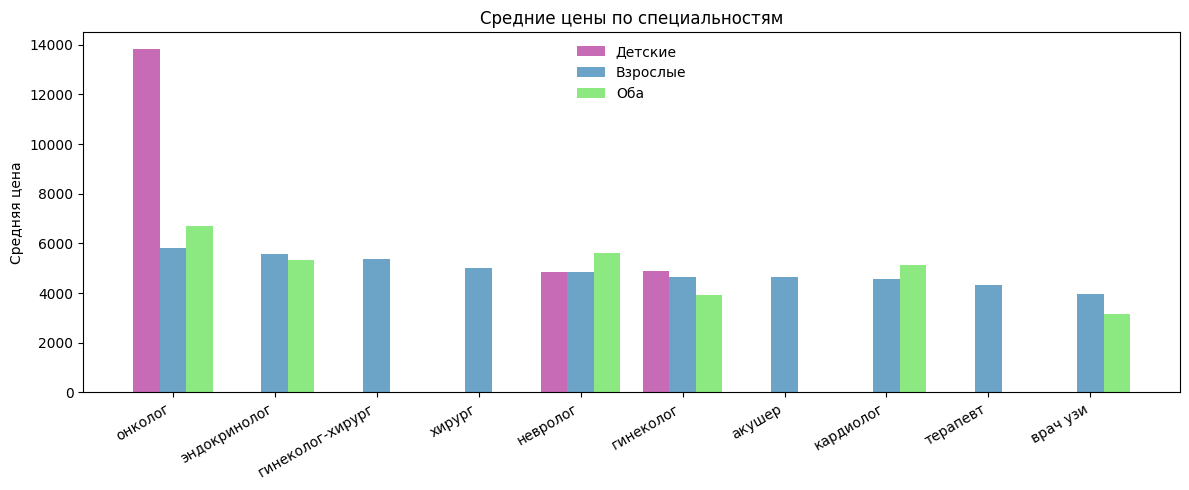

In [124]:
def label_row(r):
    if r['is_kids']==1 and r['is_adults']==1:
        return 'Оба'
    elif r['is_kids']==1:
        return 'Детские'
    elif r['is_adults']==1:
        return 'Взрослые'
groups_order = ['Детские','Взрослые','Оба']
colors = {
    'Детские': '#c76bb6',
    'Взрослые': '#6ba4c7',
    'Оба': '#8ce880',
}

new_df['group'] = new_df.apply(label_row, axis=1)

# возьмём топ-10 популярных специальностей по числу записей)
top_specs = new_df['speciality'].value_counts().head(10).index
doctors_top = new_df[new_df['speciality'].isin(top_specs)].copy()

# порядок специальностей - по средней цене для взрослых
order = (doctors_top[doctors_top['group']=='Взрослые'].groupby('speciality')['price'].mean().sort_values(ascending=False))
order = order.index
doctors_top['speciality'] = pd.Categorical(doctors_top['speciality'], categories=order, ordered=True)

med = (doctors_top
       .groupby(['speciality','group'])['price']
       .mean()
       .unstack() # столбцы = группы
       .reindex(columns=groups_order)) # фиксируем порядок столбцов

x = np.arange(len(med.index))
w = 0.26

plt.figure(figsize=(12,5))
for i, g in enumerate(groups_order):
    if g in med.columns:
        plt.bar(x + (i-1)*w, med[g].values, width=w, label=g, color=colors.get(g, None))
        '''
        Идем по группам в нужном порядке. enumerate даёт индекс i (0,1,2). смещаем столбики каждой группы относительно центров x:
        при i=0 позиция x - w (левее), при i=1 позиция x + 0*w (по центру), при i=2 позиция x + w (правее)
        '''

plt.xticks(x, med.index, rotation=30, ha='right')
plt.ylabel('Средняя цена')
plt.title('Средние цены по специальностям')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Видим, что у онкологов принимающих детей цена сильно выше всех остальных. Далее цены для детей и взрослых примерно одинаковые

#Метро (`metro`)

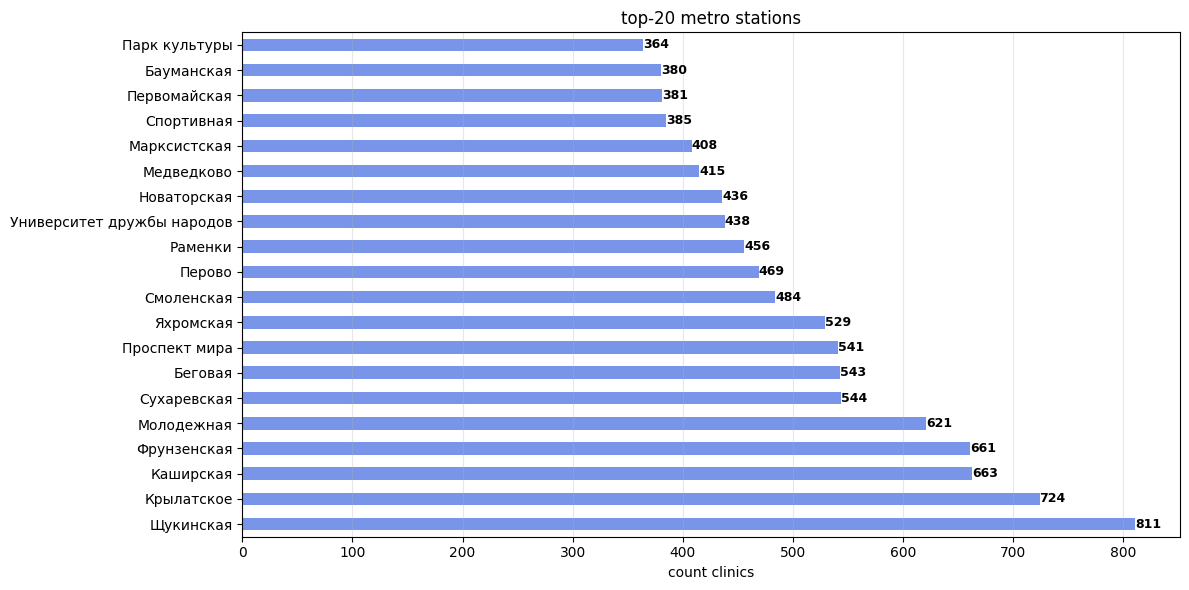

In [125]:
plt.figure(figsize=(12,6))

all_metro_stations = []
metro_columns = [col for col in doctors.columns if 'metro' in col]
for col in metro_columns:
    metro_data = doctors[col].dropna()
    all_metro_stations.extend(metro_data)

metro_counts = pd.Series(all_metro_stations).value_counts()
top_20_metro = metro_counts.head(20)
top_20_metro.plot(kind='barh', color='royalblue', alpha=0.7)
plt.title('top-20 metro stations')
plt.xlabel('count clinics')
plt.grid(axis='x', alpha=0.3)

for i, count in enumerate(top_20_metro.values):
    plt.text(count, i, str(count), va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [126]:
metro_counts

,count
Щукинская,811
Крылатское,724
Каширская,663
Фрунзенская,661
Молодежная,621
...,...
Звёздная,1
Кремлёвская,1
Площадь 1905 года,1
Козья слобода,1


# Число клиник (clinics_count)

In [127]:
int(doctors['clinics_count_sber'].max())

8

In [128]:
doctors['clinics_count_sber'].value_counts()

,count
clinics_count_sber,
0.0,27559
1.0,3492
2.0,726
3.0,115
4.0,16
5.0,10
8.0,1


In [129]:
doctors['clinics_count_prod'].value_counts()

,count
clinics_count_prod,
1.0,16986
2.0,6057
3.0,1881
4.0,497
5.0,158
6.0,57
7.0,11
9.0,4
8.0,4


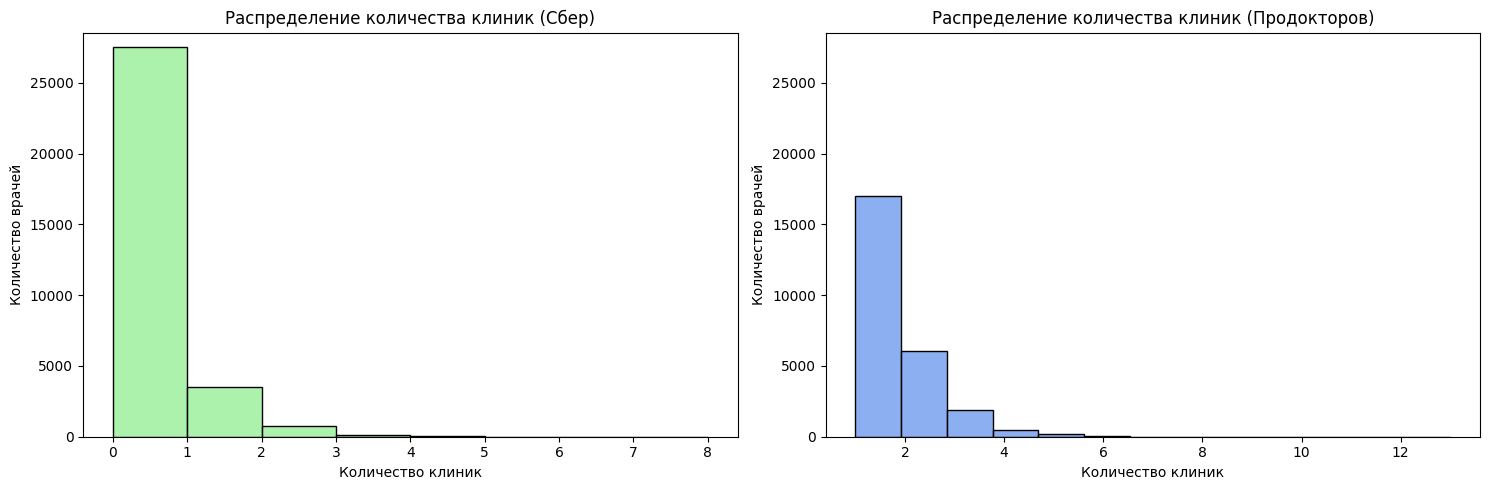

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1, ax2 = axes

sns.histplot(data=doctors, x='clinics_count_sber', bins=int(doctors['clinics_count_sber'].max()), ax=ax1,color = 'lightgreen')
ax1.set_title('Распределение количества клиник (Сбер)')
ax1.set_xlabel('Количество клиник')
ax1.set_ylabel('Количество врачей')
ax1.set_ylim(0, 27559+1000)

sns.histplot(data=doctors, x='clinics_count_prod', bins=int(doctors['clinics_count_prod'].max()), ax=ax2,color = 'cornflowerblue')
ax2.set_title('Распределение количества клиник (Продокторов)')
ax2.set_xlabel('Количество клиник')
ax2.set_ylabel('Количество врачей')
ax2.set_ylim(0, 27559+1000)

plt.tight_layout()
plt.show()

In [131]:
doctors['clinics_count_prod'].value_counts()

,count
clinics_count_prod,
1.0,16986
2.0,6057
3.0,1881
4.0,497
5.0,158
6.0,57
7.0,11
9.0,4
8.0,4


На Продокторов чаще есть информация о клиниках

#Основные выводы по унивариативному анализу и анализу в целом на текущий момент



1) **Качество и структура данных**

В выборке около 40 000 врачей. Заполненность данных очень сильно варьируется: цена и опыт очень много где не заполнены. Стаж можно не указывать, а цена скрывается если врач не принимает.Тем не менее мы можем сравнить ключевые показатели — стоимость, рейтинг и распространённость специальностей.

**Вывод:** данные репрезентативны для анализа рыночных тенденций и ценовых различий между платформами, несмотря на естественные пропуски.
Это кстати как раз подтверждает актуальность идеи нашего проекта: пользователи не могут получить единый, прозрачный источник. Даже при ограниченных данных видно, что цены, рейтинги и характеристики врачей несогласованы

2) **Распределение цен**

Распределение конечно асимметричное, с длинным правым хвостом.
Основная масса врачей принимает в диапазоне 2 500–4 000.
Выбросы встречаются вплоть до 150 000 за сессию))), что мы видим у узких премиум специалистов.
Разброс цен внутри одной специальности остаётся значительным

**Вывод:** медианный приём в Москве стоит около 3 000, но рынок сильно сегментирован по цене и специализации.

3) **Сравнение платформ**

Для одних и тех же специалистов:
45% цен совпадают,
40% выше на СберЗдоровье,

**Вывод:** ценовая политика платформ в целом схожа, но СберЗдоровье имеет тенденцию к чуть более высоким ценам


#Мультивариантивный анализ

#Корреляции (Heatmap)

##Корреляция Пирсона

<Axes: >

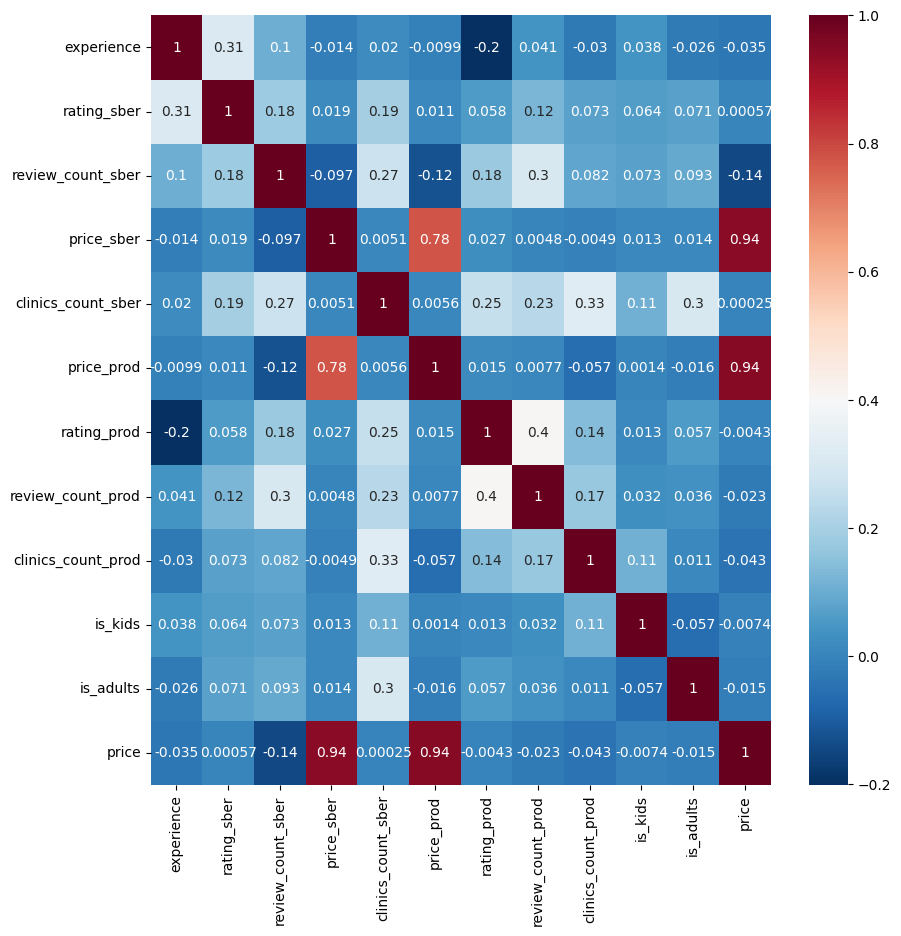

In [132]:
plt.figure(figsize=(10,10))
sns.heatmap(doctors.corr(numeric_only = True), annot=True, cmap='RdBu_r')

Сильная корреляция наблюдается только между ценами на двух платформах, что подтверждает корректное сопоставление врачей при мердже
Между остальными переменными линейный связи не найдены.

**Вывод:** ключевые параметры в целом не имеют линейных зависимостей

##Корреляция Спирмена

- измеряет монотонную (возрастающую или убывающую, но не обязательно линейную)зависимость между переменными.

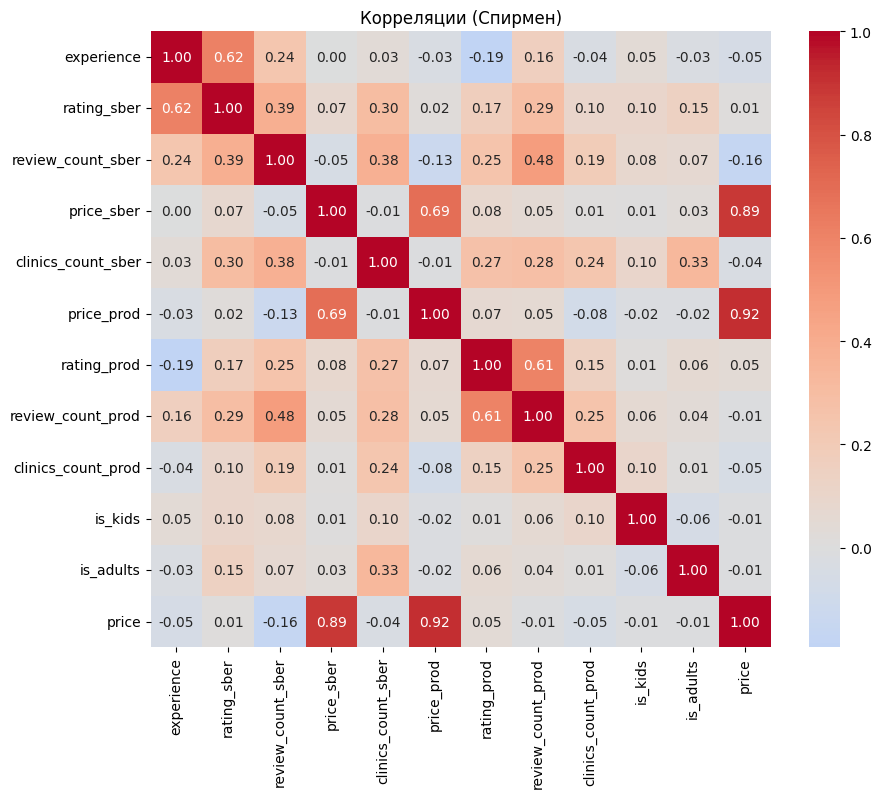

In [133]:
corr = doctors.corr(method='spearman', numeric_only=True)


plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Корреляции (Спирмен)')
plt.show()





**1. Опыт и рейтинг**

* Между опытом и рейтингом на СберЗдоровье умеренная положительная корреляция (0.6).
* На ПроДокторов слабая отрицательная (около –0.2).

  Вывод: опытные врачи оцениваются выше на Сбере, тогда как на ПроДокторов стаж почти не влияет на рейтинг

**2. Рейтинг и количество отзывов**

* На обеих платформах наблюдается слабая положительная корреляция (0.4): больше отзывов: немного выше рейтинг

**3. Связь между платформами**

* Количество отзывов слегка коррелирует между платформами (0.5).
* Цены сильно коррелируют (0.9)

**4. Количество клиник и отзывы**

* Между числом клиник и отзывов: умеренная положительная связь (0.5): врачи, работающие в нескольких клиниках, получают больше отзывов.

**5. Общие наблюдения**

* Присутствуют нелинейные корреляции
* Сильных корреляций, кроме ценовых, нет
* Основные связи наблюдаются между ценами, отзывами и рейтингами внутри одной платформы
* В остальном признаки слабо связаны, что говорит о неоднородности данных и различиях между платформами


#Стаж и цена

<Figure size 1600x900 with 0 Axes>

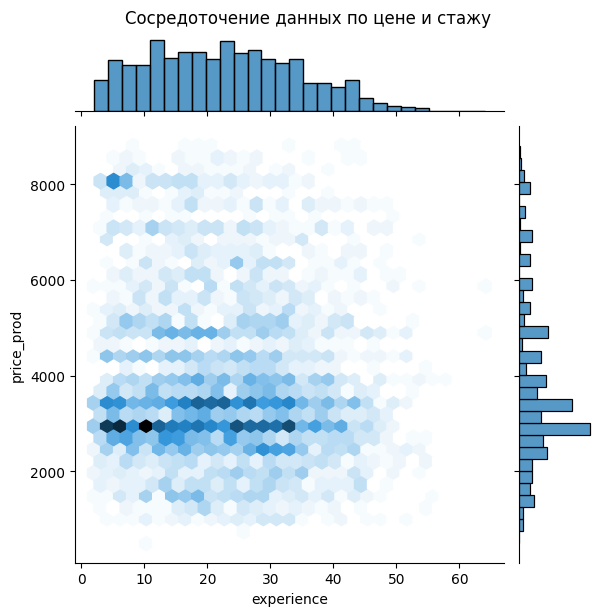

<Figure size 640x480 with 0 Axes>

In [134]:
plt.figure(figsize=(16, 9))

doctors_1 = doctors[doctors['price_prod'] < 9000]

sns.jointplot(x='experience', y='price_prod', data=doctors_1, kind='hex')

plt.suptitle('Сосредоточение данных по цене и стажу', y=1.02)
plt.show()

plt.tight_layout()

In [135]:
doctors_1 = doctors[doctors['price'] < 9000]

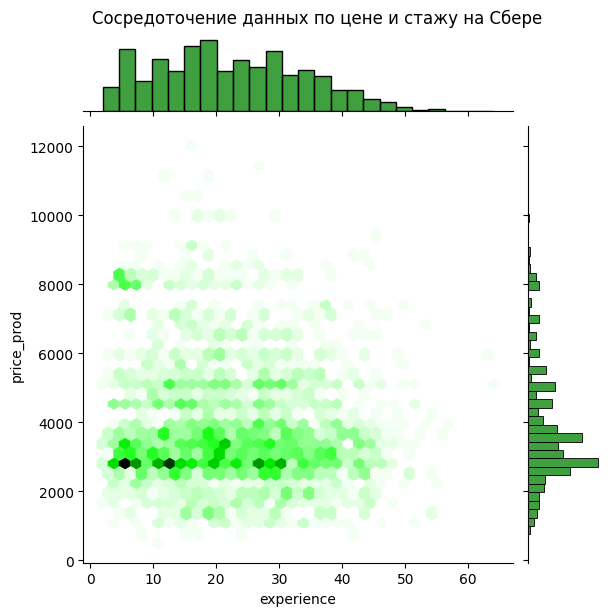

In [136]:
sns.jointplot(x='experience', y='price_prod', data=doctors_1, kind='hex',color = 'green')
plt.suptitle('Сосредоточение данных по цене и стажу на Сбере', y=1.02)
plt.show()

Нету роста стоимости приёма с увеличением стажа на обеих платформах

Основная масса врачей (5–25 лет опыта) концентрируется в диапазоне 2500–4000 ₽, при этом даже врачи с опытом более 30 лет не имеют существенно более высоких цен. Это указывает на слабую монетизацию опыта и унифицированное ценообразование внутри платформы.

Кластеризация? (еще в доработке)

<Axes: xlabel='price_prod', ylabel='rating_prod'>

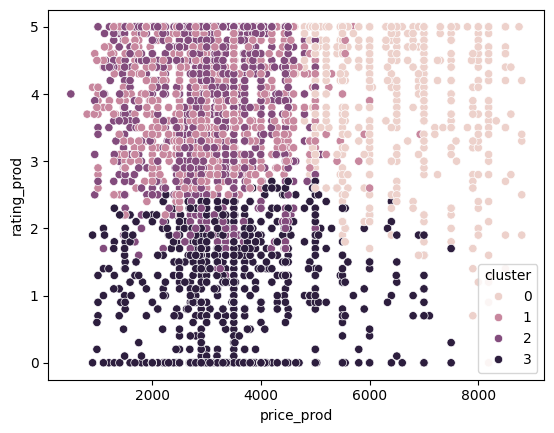

In [137]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

doctors_1 = doctors[doctors['price_prod'] < 9000]

features = doctors_1[['price_prod','rating_prod','experience']].dropna()
scaled = StandardScaler().fit_transform(features)
kmeans = KMeans(n_clusters=4, random_state=42).fit(scaled)
features['cluster'] = kmeans.labels_
sns.scatterplot(x='price_prod', y='rating_prod', hue='cluster', data=features)

<Axes: xlabel='price_sber', ylabel='rating_sber'>

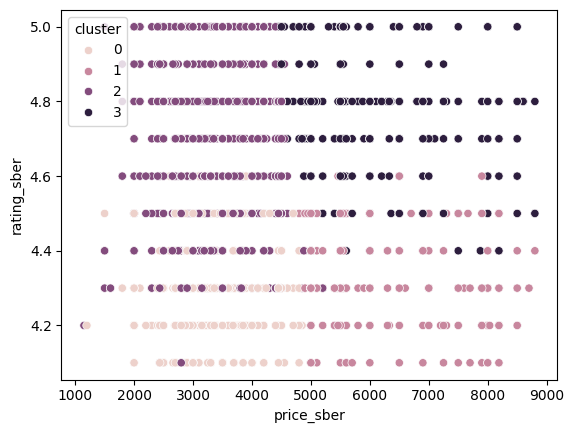

In [138]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

doctors_1 = doctors[(doctors['price_sber'] < 9000)&(doctors['rating_sber'] > 4)]

features = doctors_1[['price_sber','rating_sber','experience']].dropna()
scaled = StandardScaler().fit_transform(features)
kmeans = KMeans(n_clusters=4, random_state=42).fit(scaled)
features['cluster'] = kmeans.labels_
sns.scatterplot(x='price_sber', y='rating_sber', hue='cluster', data=features)